In [77]:
import os
from typing import List
import tempfile
from tqdm import tqdm
from itertools import combinations, product
import numpy as np
import pandas as pd
import torch
import cv2
from groundingdino.util.inference import Model
from ultralytics import SAM
from ultralytics.models.sam import Predictor as SAMPredictor
import supervision as sv

HOME = os.getcwd()

# !git clone https://github.com/IDEA-Research/GroundingDINO.git

# %cd {HOME}/GroundingDINO
# %pip install -q -e .

# set model configuration file path
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")

# %cd {HOME}/GroundingDINO/weights
# !wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

# set model weight file path
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "GroundingDINO/weights", WEIGHTS_NAME)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

grounding_dino_model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

def enhance_class_name(class_names:List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

def get_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def dino_process(image_path, model, classes=None, text_prompt=None, to_prompt=False):
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.35

    image = cv2.imread(image_path)
    
    if classes is not None:
        class_dict = dict(zip(classes, range(len(classes))))
        if to_prompt==False:
            detections = model.predict_with_classes(
                image=image,
                classes=classes, #enhance_class_name(class_names=classes)
                box_threshold=BOX_THRESHOLD,
                text_threshold=TEXT_THRESHOLD
            )
            labels = [
                f"{classes[class_id]}"
                for _, _, _, class_id, _
                in detections]            
            img_labels = [
                f"{classes[class_id]} {confidence:0.2f}"
                for _, _, confidence, class_id, _
                in detections]
        else:
            prompt = ", ".join(classes)
            detections, labels = model.predict_with_caption(
                image=image,
                caption=prompt,
                box_threshold=BOX_THRESHOLD,
                text_threshold=TEXT_THRESHOLD
            )
            # get only detections which in classes
            # 1.get index
            detect_index = []
            detect_dict = {}
            for i in classes:
                detect_dict[i] = list(filter(lambda x: labels[x] == i, range(len(labels))))
                detect_index = detect_index + list(filter(lambda x: labels[x] == i, range(len(labels))))
            # 2.get detection result in classes
            for class_c in list(combinations(detect_dict.keys(), 2)):
                for box_c in product(detect_dict[class_c[0]], detect_dict[class_c[1]]):
                    box_iou = get_iou(detections.xyxy[box_c[0]], detections.xyxy[box_c[1]])
                    if box_iou >= 0.9:
                        if detections.confidence[box_c[0]] >= detections.confidence[box_c[1]]:
                            detect_index.remove(box_c[1])
                        else:
                            detect_index.remove(box_c[0])
            # 3.update labels
            labels = np.array(labels)[detect_index]
            # 4.update detections
            detections.xyxy = np.array(detections.xyxy)[detect_index]
            detections.confidence = np.array(detections.confidence)[detect_index]
            detections.class_id = np.array([class_dict[x] for x in labels])
            # 5.make img_labels
            img_labels = [
                f"{label} {confidence:0.2f}"
                for label, (_, _, confidence, class_id, _)
                in zip(labels, detections)]

    if (classes is None) & (text_prompt is not None):
        detections, labels = model.predict_with_caption(
            image=image,
            caption=text_prompt,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )
        img_labels = [
            f"{label} {confidence:0.2f}"
            for label, (_, _, confidence, class_id, _)
            in zip(labels, detections)]


    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=img_labels)

    return detections, labels, img_labels, annotated_image

def segment_process(image, detections, img_size, model_nm="mobile_sam.pt"):
    overrides = dict(conf=0.25, task='segment', mode='predict', imgsz=img_size, model=model_nm)
    predictor = SAMPredictor(overrides=overrides)
    predictor.set_image(image)
    result_polygon = []
    for box in detections.xyxy:
        result = predictor(
            bboxes=box,
        )
        result_polygon.append(np.squeeze(result[0].masks.xyn).tolist())
    
    return result_polygon


final text_encoder_type: bert-base-uncased


In [2]:
input_video_path = './Soccer_Players/korea_soccer_cut.mp4'
output_video_path = './Soccer_Players/auto_annotate/output_video.mp4'
detect_path = './Soccer_Players/auto_annotate/detect'
non_detect_path = './Soccer_Players/auto_annotate/non_detect'
class_lst = ["red team", "blue team", "yellow clothes person"]
# text_prompt = ", ".join(class_lst)
# text_prompt = "red team soccer player and blue team soccer player and yellow shirt refree"
# print(text_prompt)


vid = cv2.VideoCapture(input_video_path)
frame_cnt = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 60, (width, height))

for _ in tqdm(range(frame_cnt)):

    if _ == 0:
        ret, frame = vid.read()

        tmp_filename = tempfile.mktemp(suffix='.jpg')
        cv2.imwrite(tmp_filename, frame)
        # get grounding DINO auto annotate result
        dino_detections, labels, label_confs, annotate_image = dino_process(tmp_filename, grounding_dino_model, classes=class_lst, text_prompt=None, to_prompt=True)
        # define box labels
        box_meta = pd.concat([pd.DataFrame(arr) for arr in [np.expand_dims(dino_detections.class_id, axis=0).T,dino_detections.xyxy]], axis=1)

        polygon_meta = segment_process(frame, dino_detections, np.shape(frame)[:2], model_nm="mobile_sam.pt")
        
        dino_detections.mask = (np.array(result_masks) * 255).astype(np.uint8)
        os.remove(tmp_filename)

        # save reulst image and labels
        # 1.make direcotry
        os.makedirs(detect_path+'/img', exist_ok=True)
        os.makedirs(detect_path+'/labels', exist_ok=True)
        os.makedirs(non_detect_path+'/img', exist_ok=True)
        
        # 2.define path
        if len(labels) > 0:
            # define path for saving annoate image            
            save_img_path = os.path.join(detect_path+'/img', f'frame_{_}.jpg')
            # define path for saving annoate labels            
            save_label_path = os.path.join(detect_path+'/labels', f'frame_{_}.txt')
            box_meta.to_csv(save_label_path, na_rep="", sep=" ", header=False, index=False)
        else:
            # define path for saving annoate image            
            save_img_path = os.path.join(non_detect_path+'/img', f'frame_{_}.jpg')

        cv2.imwrite(save_img_path, frame)
        result.write(frame)

result.release()
vid.release()

  0%|          | 0/34997 [00:00<?, ?it/s]c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 34997/34997 [00:01<00:00, 18955.50it/s]


In [3]:
from ultralytics import SAM
from ultralytics.models.sam import Predictor as SAMPredictor
import torch
import numpy as np
import cv2
import time

In [78]:
a = segment_process(frame, dino_detections, np.shape(frame)[:2], model_nm="mobile_sam.pt")

Ultralytics YOLOv8.0.223 🚀 Python-3.10.13 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)

0: 1024x1024 17.2ms
Speed: 0.0ms preprocess, 17.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict22

0: 1024x1024 13.9ms
Speed: 0.0ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict22

0: 1024x1024 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict22

0: 1024x1024 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict22

0: 1024x1024 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict22

0: 1024x1024 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (

In [79]:
a

[[[0.35729166865348816, 0.6509259343147278],
  [0.3567708432674408, 0.6518518328666687],
  [0.3557291626930237, 0.6518518328666687],
  [0.3552083373069763, 0.6527777910232544],
  [0.35468751192092896, 0.6527777910232544],
  [0.3541666567325592, 0.6537036895751953],
  [0.35364583134651184, 0.6537036895751953],
  [0.35208332538604736, 0.6564815044403076],
  [0.35208332538604736, 0.6592592597007751],
  [0.3515625, 0.6601851582527161],
  [0.3515625, 0.6611111164093018],
  [0.35104167461395264, 0.6620370149612427],
  [0.35104167461395264, 0.6629629731178284],
  [0.35208332538604736, 0.664814829826355],
  [0.35208332538604736, 0.6657407283782959],
  [0.35624998807907104, 0.6731481552124023],
  [0.35624998807907104, 0.675000011920929],
  [0.3567708432674408, 0.6759259104728699],
  [0.3567708432674408, 0.6796296238899231],
  [0.35729166865348816, 0.6805555820465088],
  [0.35729166865348816, 0.6879629492759705],
  [0.3578124940395355, 0.6888889074325562],
  [0.3578124940395355, 0.69537037611007

In [55]:

dino_detections.mask = np.squeeze((np.array(result_masks) * 255).astype(np.uint8))

    # masks = result[0].masks
    # index = np.argmax(scores)
    # result_masks.append(masks[index])

In [68]:
np.shape(frame)[:2]

(1080, 1920)

In [64]:
overrides = dict(conf=0.25, task='segment', mode='predict', imgsz=(1028,1920), model="mobile_sam.pt")
predictor = SAMPredictor(overrides=overrides)
predictor.set_image(frame)
result_masks = []
for box in dino_detections.xyxy:
    result = predictor(
        bboxes=box,
    )
    print(np.shape(result[0].masks.data.cpu().tolist()))
    print(result[0].masks.xyn)
    print(np.shape(result[0].masks.xyn))

    # result_masks.append(result[0].masks.data.cpu().tolist())

Ultralytics YOLOv8.0.223 🚀 Python-3.10.13 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)

0: 1024x1024 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict19
(1, 1080, 1920)
[array([[    0.35729,     0.65093],
       [    0.35677,     0.65185],
       [    0.35573,     0.65185],
       [    0.35521,     0.65278],
       [    0.35469,     0.65278],
       [    0.35417,      0.6537],
       [    0.35365,      0.6537],
       [    0.35208,     0.65648],
       [    0.35208,     0.65926],
       [    0.35156,     0.66019],
       [    0.35156,     0.66111],
       [    0.35104,     0.66204],
       [    0.35104,     0.66296],
       [    0.35208,     0.66481],
       [    0.35208,     0.66574],
       [    0.35625,     0.67315],
       [    0.35625,       0.675],
       [    0.35677,     0.67593],
       [    0.35677,     0.67963],
       [    0.35729,     0.68056],
       [    0.35729,     

In [65]:
np.shape(sv.mask_to_polygons(dino_detections.mask[0]))


(1, 69, 2)

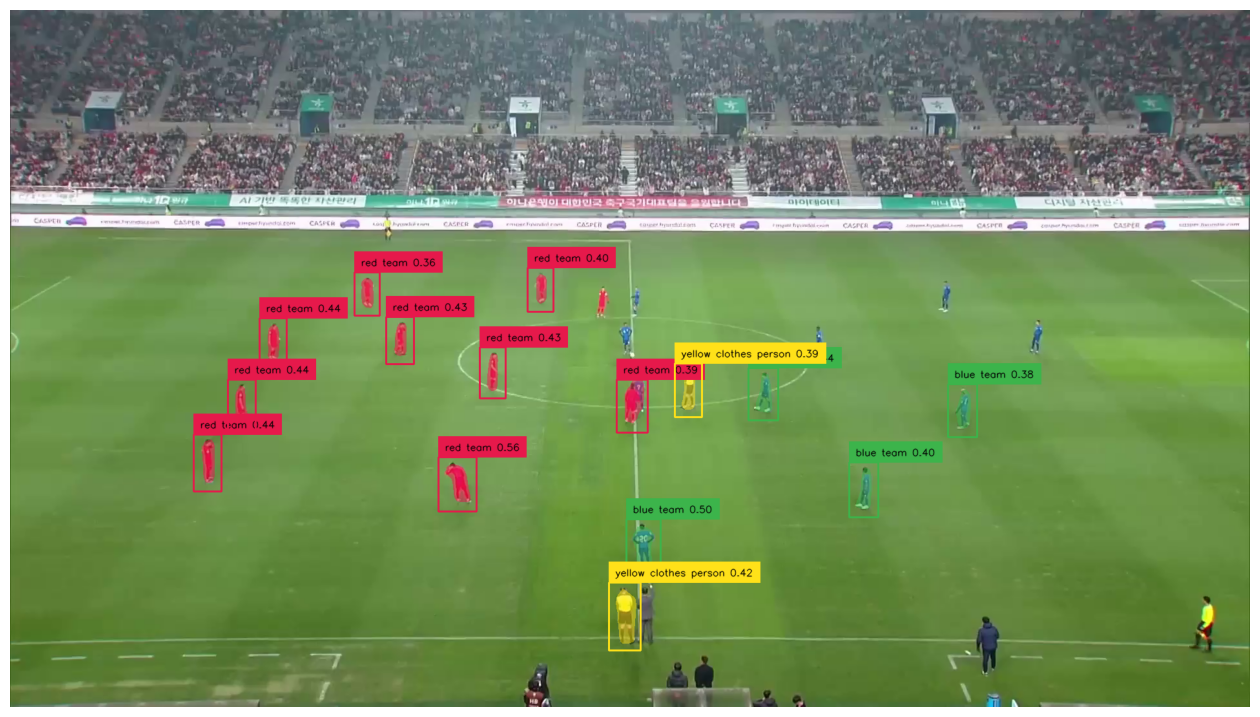

In [10]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(scene=frame, detections=dino_detections)
fin_annotated_image = box_annotator.annotate(scene=annotated_image[0], detections=dino_detections, labels=labels)

%matplotlib inline
sv.plot_image(fin_annotated_image, (16, 16))

In [34]:
set(dino_detections.mask[0].flatten())

{0, 255}

In [13]:
np.shape(frame)

(1080, 1920, 3)

In [16]:
np.shape(scene[0])

(1080, 1920, 3)

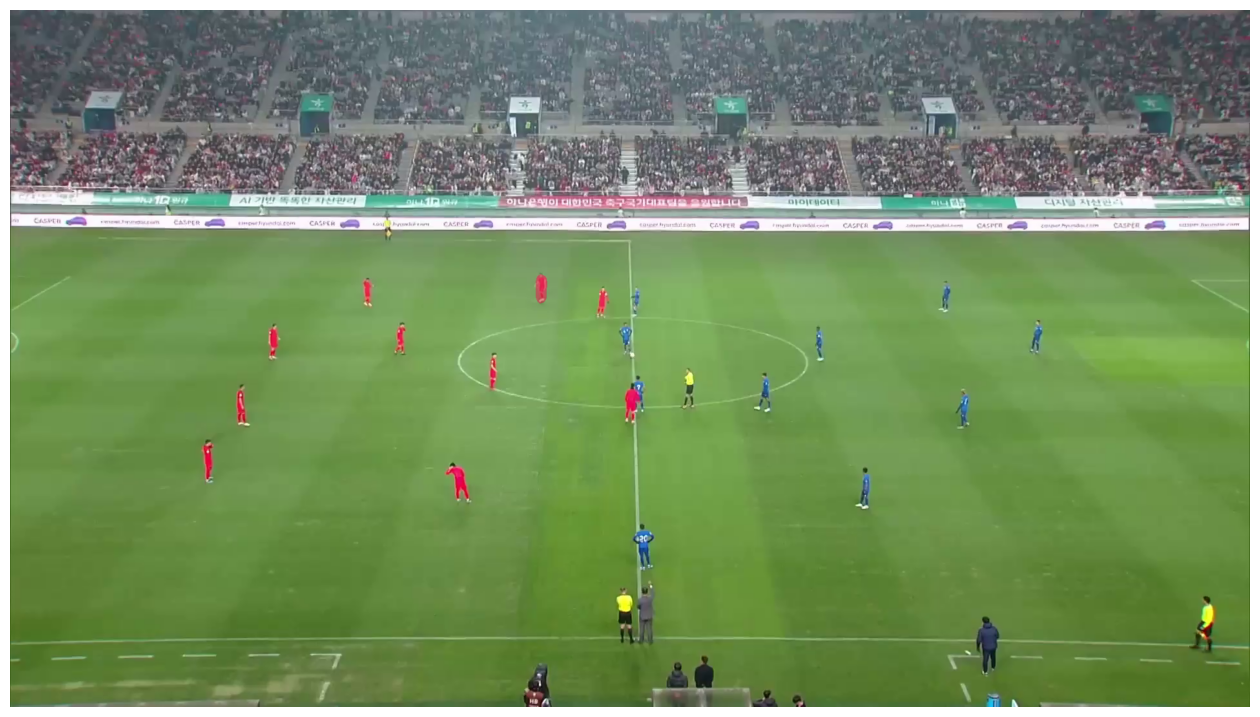

In [17]:
sv.plot_image(scene[0], (16, 16))

In [71]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(np.array(masks.data.cpu()))))

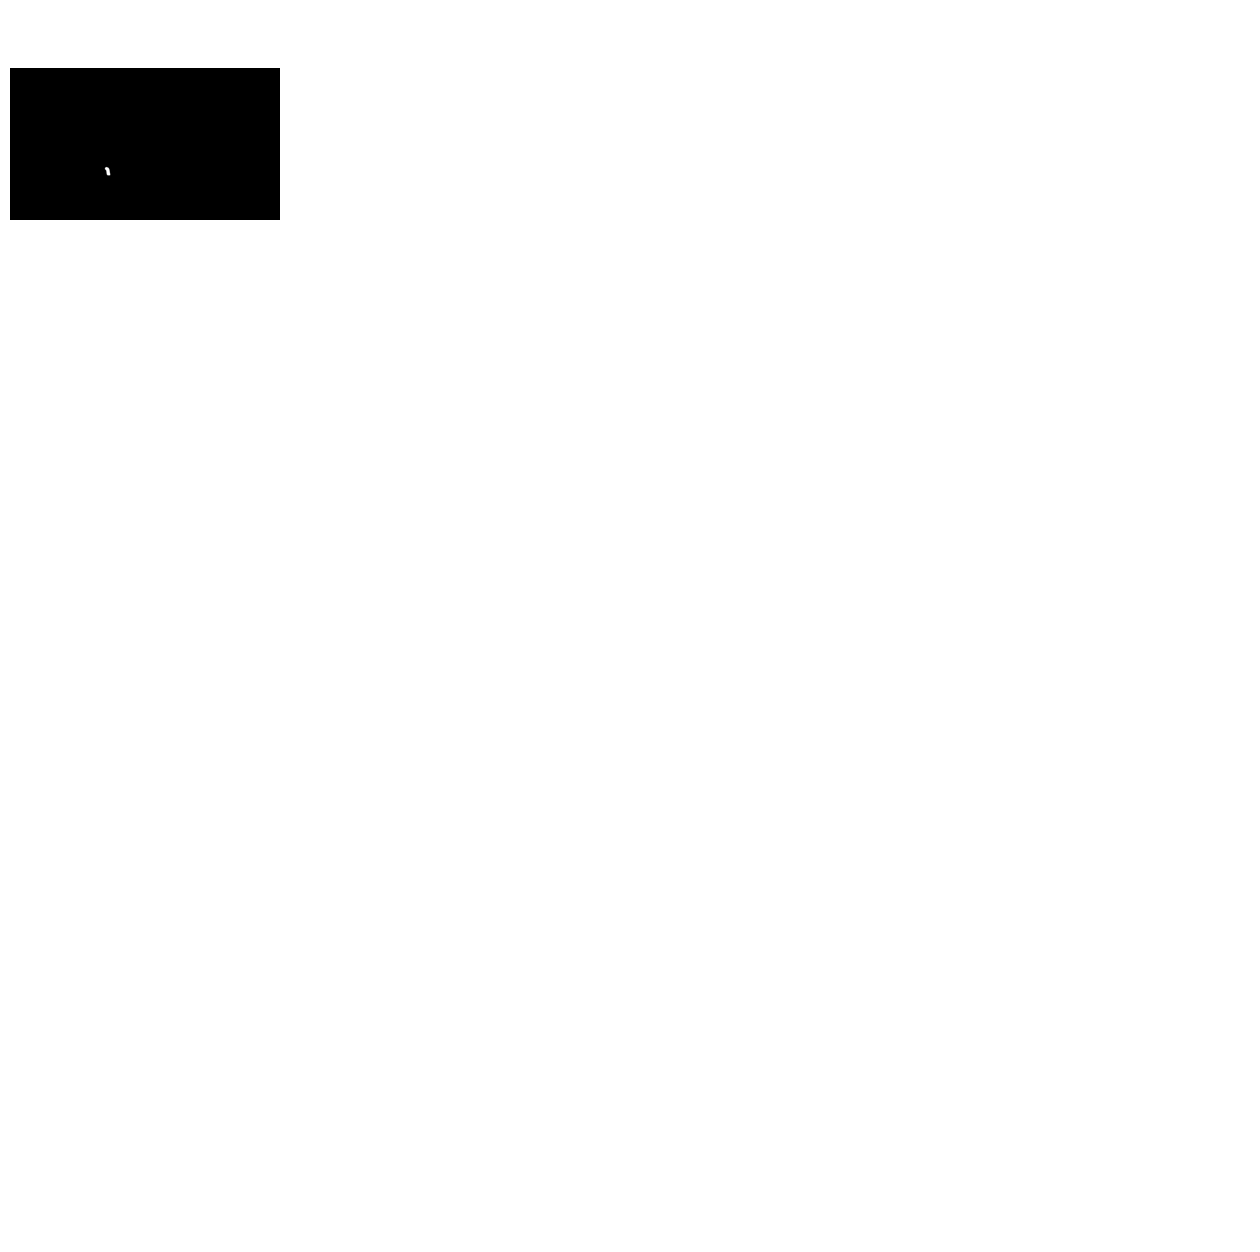

In [35]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(dino_detections.mask)))

sv.plot_images_grid(
    images=dino_detections.mask[0],
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16)
)


In [50]:
img_path = save_img_path
result_masks = []
for box in dino_detections.xyxy:
    result= sam_model.predict(
        save_img_path,
        bboxes=box,
        multimask_output=True
    )
    masks = result[0].masks
    probs = result[0].probs
    # masks, scores, logits
    # index = np.argmax(scores)
    # result_masks.append(masks[index])

SyntaxError: '[31m[1mmultimask_output[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '--f=c:\\Users\\Hyosk5\\AppData\\Roaming\\jupyter\\runtime\\kernel-v2-165925t8XM5JgHiL4.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco128.yaml model=yolov8n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolov8n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolov8n.pt data=coco128.yaml batch=1 imgsz=640

    4. Export a YOLOv8n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolov8n-cls.pt format=onnx imgsz=224,128

    5. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg

    Docs: https://docs.ultralytics.com
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

Ultralytics YOLOv8.0.223 🚀 Python-3.10.13 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
[      663.3      693.45       722.8      777.68]

0: 1024x1024 19.0ms
Speed: 0.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict13
[     386.21      478.81      428.89      556.08]

0: 1024x1024 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict13
[     582.95      476.78      625.02      549.28]

0: 1024x1024 18.1ms
Speed: 0.0ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict13
[     284.82      658.14      327.97      746.27]

0: 1024x1024 15.8ms
Speed: 0.0ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict13
[     337.27      573.63      380.33      657.73]

0: 1024x1

In [63]:
frame

array([[[ 87,  80,  77],
        [ 87,  80,  77],
        [ 88,  81,  78],
        ...,
        [ 68,  69,  56],
        [ 69,  70,  57],
        [ 69,  70,  57]],

       [[ 87,  80,  77],
        [ 87,  80,  77],
        [ 88,  81,  78],
        ...,
        [ 68,  69,  56],
        [ 69,  70,  57],
        [ 69,  70,  57]],

       [[ 87,  80,  77],
        [ 87,  80,  77],
        [ 88,  81,  78],
        ...,
        [ 69,  70,  57],
        [ 70,  71,  58],
        [ 70,  71,  58]],

       ...,

       [[ 43,  91,  56],
        [ 71, 119,  84],
        [ 70, 118,  83],
        ...,
        [ 33, 113,  78],
        [ 29, 109,  74],
        [ 20, 100,  65]],

       [[ 54,  95,  61],
        [ 82, 123,  89],
        [ 81, 122,  88],
        ...,
        [ 33, 113,  78],
        [ 29, 109,  74],
        [ 20, 100,  65]],

       [[ 56,  97,  63],
        [ 84, 125,  91],
        [ 83, 124,  90],
        ...,
        [ 33, 113,  78],
        [ 29, 109,  74],
        [ 20, 100,  65]]

In [45]:
overrides = dict(conf=0.25, task='segment', mode='predict', imgsz=(1920,1080), model="mobile_sam.pt")
predictor = SAMPredictor(overrides=overrides)
results = predictor(source=save_img_path, crop_n_layers=1, points_stride=64)


Ultralytics YOLOv8.0.223 🚀 Python-3.10.13 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
image 1/1 d:\vision\Soccer_Players\auto_annotate\detect\img\frame_0.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 1 124, 1 125, 1 126, 1 127, 1 128, 1 129, 1 130, 1 131, 16

In [26]:
probs

In [69]:
from ultralytics.data.annotator import auto_annotate
auto_annotate(data='./Soccer_Players/auto_annotate/detect/img/frame_0.jpg', det_model='yolov8x.pt', sam_model='sam_b.pt')    



100%|██████████| 131M/131M [00:02<00:00, 45.9MB/s] 



image 1/1 d:\vision\Soccer_Players\auto_annotate\detect\img\frame_0.jpg: 384x640 27 persons, 8400.1ms
Speed: 3.2ms preprocess, 8400.1ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


In [167]:
annotate_lst
d = {x: i for i, x in enumerate(set(annotate_lst))}
lst_new = [d[x] for x in annotate_lst]
print(lst_new)
print(d)

[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 3, 4, 4]
{'blue team': 0, 'blue': 1, 'red team': 2, 'team': 3, 'yellow clothes person': 4}


In [155]:
start_time = time()
del_index_lst = []
for class_c in list(combinations(class_dict.keys(), 2)):
    for box_c in product(class_dict[class_c[0]], class_dict[class_c[1]]):
        box_iou = get_iou(dino_detections.xyxy[box_c[0]], dino_detections.xyxy[box_c[1]])
        if box_iou >= 0.9:
            if dino_detections.confidence[box_c[0]] >= dino_detections.confidence[box_c[1]]:
                del_index_lst.append(box_c[1])
            else:
                del_index_lst.append(box_c[0])

end_time = time()

duration = end_time - start_time

print(duration)

0.0020110607147216797


In [168]:
dino_detections.xyxy

array([[ 663.2969 ,  693.45135,  722.7998 ,  777.6789 ],
       [ 386.21454,  478.81018,  428.89117,  556.08386],
       [ 582.94574,  476.77872,  625.0212 ,  549.27704],
       [ 663.3031 ,  693.40125,  723.1742 ,  777.8447 ],
       [ 284.82474,  658.1353 ,  327.97458,  746.2673 ],
       [ 337.27472,  573.632  ,  380.33472,  657.7276 ],
       [ 939.1672 ,  573.8993 ,  987.98444,  655.0541 ],
       [ 801.5145 ,  400.3352 ,  841.7389 ,  468.30798],
       [ 533.2273 ,  407.15756,  572.86487,  474.04813],
       [ 727.451  ,  523.8592 ,  767.3287 ,  602.664  ],
       [ 954.70825,  789.8242 , 1007.03845,  878.48584],
       [ 386.223  ,  478.97852,  428.762  ,  556.05225],
       [ 583.16266,  476.93298,  625.1794 ,  549.1726 ],
       [ 284.57178,  658.1488 ,  328.21094,  746.28845],
       [ 727.6265 ,  524.03906,  767.57574,  602.7223 ],
       [ 337.31317,  573.7738 ,  380.45074,  657.7683 ],
       [1143.0741 ,  555.46906, 1189.6837 ,  636.56793],
       [1452.5826 ,  580.9375 ,

In [156]:
start_time = time()
del_index_lst2 = []
for c in list(combinations(l, 2)):
    box_iou = get_iou(dino_detections.xyxy[c[0]], dino_detections.xyxy[c[1]])
    if box_iou >= 0.9:
        if dino_detections.confidence[c[0]] >= dino_detections.confidence[c[1]]:
            del_index_lst2.append(c[1])
        else:
            del_index_lst2.append(c[0])

end_time = time()

duration = end_time - start_time

print(duration)

0.002000093460083008


In [84]:
import numpy as np

all_index = []
for i in class_lst:
    all_index = all_index + list(filter(lambda x: annotate_lst[x] == i, range(len(annotate_lst))))
    print(all_index)
   

[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 3, 10, 16, 17, 18]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 3, 10, 16, 17, 18, 20, 21]


In [157]:
print(l)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 3, 10, 16, 17, 18, 20, 21]


In [159]:
l.remove([3,21])

ValueError: list.remove(x): x not in list

In [26]:
from ultralytics import SAM
from ultralytics.models.sam import Predictor as SAMPredictor
import torch
import numpy as np
import cv2
import time

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cuda


In [29]:
model = SAM('sam_b.pt')
model.info()



# image = cv2.imread("./Soccer_Players/train/images/USA_NED-Qatar2022_mp4-0_jpg.rf.eedd993d9dde9db671f8a75c43319450.jpg")


100%|██████████| 358M/358M [00:25<00:00, 14.7MB/s] 


Model summary: 238 layers, 93735472 parameters, 93735472 gradients


(238, 93735472, 93735472, 0)

In [23]:
prompt_process = FastSAMPrompt(image, everything_results, device=DEVICE)


In [24]:
text_prompt = "playing soccer"
ann = prompt_process.text_prompt(text=text_prompt)

In [25]:
prompt_process.plot(annotations=ann, output='./Soccer_Players/fastsam_annotate/detect')

Saving image0.jpg to Soccer_Players\fastsam_annotate\detect\image0.jpg: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


In [ ]:
model = FastSAM('FastSAM-x.pt')

def process_image(image_path, model, output_path, text_prompt=None):

  image = cv2.imread(image_path)

  everything_results = model(
      source=image
    , device=DEVICE
    , retina_masks=True
    , imgsz=1024
    , conf=0.4
    , iou=0.9
  )

  prompt_process = FastSAMPrompt(image, everything_results, device=DEVICE)

  ann = prompt_process.text_prompt(text=text_prompt)

  prompt_process.plot(annotation=ann, output=output_path)

  







  

In [ ]:
input_video_path = './Soccer_Players/korea_soccer_cut.mp4'
output_video_path = './Soccer_Players/fastsam_annotate/output_video.mp4'
output_detect_path = './Soccer_Players/fastsam_annotate/detect'
output_non_detect_path = './Soccer_Players/fastsam_annotate/non_detect'
text_prompt = "red team and blue team and yellow refree are playing soccer"

In [ ]:
from typing import List
import supervision as sv
import cv2
import random
random.seed(2023)

In [ ]:
def process_image(image_path, model, classes=None, text_prompt=None):
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25

    image = cv2.imread(image_path)
    
    if (classes is not None) & (text_prompt is None):
        detections = model.predict_with_classes(
            image=image,
            classes=enhance_class_name(class_names=classes),
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )

        labels = [
            f"{classes[class_id]} {confidence:0.2f}"
            for _, _, confidence, class_id, _
            in detections]

    if (classes is None) & (text_prompt is not None):
        detections, labels = model.predict_with_caption(
            image=image,
            caption=text_prompt,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )

        labels = [
            f"{label} {confidence:0.2f}"
            for label, (_, _, confidence, class_id, _)
            in zip(labels, detections)]

    print(labels)
    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=labels)

    return annotated_image, labels


In [ ]:
import os
import cv2
from tqdm import tqdm
import supervision as sv
import tempfile

input_video_path = './Soccer_Players/korea_soccer_cut.mp4'
output_video_path = './Soccer_Players/dino_annotate/output_video.mp4'
output_detect_path = './Soccer_Players/dino_annotate/detect'
output_non_detect_path = './Soccer_Players/dino_annotate/non_detect'
# class_lst = ["red team soccer player", "blue team soccer player", "yellow refree"]
# text_prompt = ", ".join(class_lst)
text_prompt = "red team soccer player and blue team soccer player and yellow refree"

os.makedirs(output_monitor_path, exist_ok=True)
os.makedirs(output_no_monitor_path, exist_ok=True)

vid = cv2.VideoCapture(input_video_path)
frame_cnt = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 60, (width, height))

for _ in tqdm(range(frame_cnt)):

    ret, frame = vid.read()

    tmp_filename = tempfile.mktemp(suffix='.jpg')
    cv2.imwrite(tmp_filename, frame)

    processed_image, labels = process_image(tmp_filename, grounding_dino_model, classes=None, text_prompt=text_prompt)

    os.remove(tmp_filename)

    if ["player", "refree"] in labels:
        save_path = os.path.join(output_detect_path, f'frame_{_}.jpg')
    else:
        save_path = os.path.join(output_non_detect_path, f'frame_{_}.jpg')

    cv2.imwrite(save_path, processed_image)

    result.write(processed_image)

result.release()
vid.release()


  0%|          | 0/34997 [00:00<?, ?it/s]

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 1/34997 [00:01<10:13:56,  1.05s/it]

['red team soccer player 0.53', 'blue team soccer player 0.43']


  0%|          | 2/34997 [00:01<5:51:54,  1.66it/s] 

['red team soccer player 0.54', 'blue team soccer player 0.43']


  0%|          | 3/34997 [00:01<4:35:48,  2.11it/s]

['red team soccer player 0.54', 'blue team soccer player 0.43']


  0%|          | 4/34997 [00:02<4:07:54,  2.35it/s]

['red team soccer player 0.55', 'blue team soccer player 0.43']


  0%|          | 5/34997 [00:02<3:51:24,  2.52it/s]

['red team soccer player 0.55', 'blue team soccer player 0.42']


  0%|          | 6/34997 [00:02<3:38:23,  2.67it/s]

['red team soccer player 0.55', 'blue team soccer player 0.43']


  0%|          | 7/34997 [00:03<3:31:45,  2.75it/s]

['red team soccer player 0.55', 'blue team soccer player 0.41']


  0%|          | 8/34997 [00:03<3:22:51,  2.87it/s]

['red team soccer player 0.55', 'blue team soccer player 0.41']


  0%|          | 9/34997 [00:03<3:11:05,  3.05it/s]

['red team soccer player 0.56', 'blue team soccer player 0.42']


  0%|          | 10/34997 [00:03<3:06:54,  3.12it/s]

['red team soccer player 0.55', 'blue team soccer player 0.42']


  0%|          | 11/34997 [00:04<3:04:53,  3.15it/s]

['red team soccer player 0.55', 'blue team soccer player 0.42']


  0%|          | 12/34997 [00:04<3:13:10,  3.02it/s]

['red team soccer player 0.54', 'blue team soccer player 0.43']


  0%|          | 13/34997 [00:04<3:09:35,  3.08it/s]

['red team soccer player 0.54', 'blue team soccer player 0.43']


  0%|          | 14/34997 [00:05<3:05:41,  3.14it/s]

['red team soccer player 0.54', 'blue team soccer player 0.43']


  0%|          | 15/34997 [00:05<3:01:02,  3.22it/s]

['red team soccer player 0.54', 'red team soccer player 0.35', 'blue team soccer player 0.42']


  0%|          | 16/34997 [00:05<3:10:17,  3.06it/s]

['red team soccer player 0.53', 'blue team soccer player 0.43']


  0%|          | 17/34997 [00:06<3:09:26,  3.08it/s]

['red team soccer player 0.53', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  0%|          | 18/34997 [00:06<3:16:16,  2.97it/s]

['red team soccer player 0.53', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  0%|          | 19/34997 [00:06<3:12:05,  3.03it/s]

['red team soccer player 0.52', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  0%|          | 20/34997 [00:07<3:10:53,  3.05it/s]

['red team soccer player 0.51', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 21/34997 [00:07<3:02:37,  3.19it/s]

['red team soccer player 0.50', 'red team soccer player 0.39', 'blue team soccer player 0.43']


  0%|          | 22/34997 [00:07<2:55:36,  3.32it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'blue team soccer player 0.43']


  0%|          | 23/34997 [00:08<2:56:25,  3.30it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'blue team soccer player 0.43']


  0%|          | 24/34997 [00:08<2:54:12,  3.35it/s]

['red team soccer player 0.47', 'red team soccer player 0.38', 'blue team soccer player 0.43']


  0%|          | 25/34997 [00:08<2:51:19,  3.40it/s]

['red team soccer player 0.47', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 26/34997 [00:08<2:52:29,  3.38it/s]

['red team soccer player 0.47', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 27/34997 [00:09<2:54:17,  3.34it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 28/34997 [00:09<2:55:01,  3.33it/s]

['red team soccer player 0.47', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.43']


  0%|          | 29/34997 [00:09<2:52:15,  3.38it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'blue team soccer player 0.43']


  0%|          | 30/34997 [00:10<2:46:59,  3.49it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.42']


  0%|          | 31/34997 [00:10<2:44:28,  3.54it/s]

['red team soccer player 0.48', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  0%|          | 32/34997 [00:10<2:43:57,  3.55it/s]

['red team soccer player 0.47', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  0%|          | 33/34997 [00:10<2:50:28,  3.42it/s]

['red team soccer player 0.46', 'red team soccer player 0.38', 'blue team soccer player 0.44']


  0%|          | 34/34997 [00:11<2:45:17,  3.53it/s]

['red team soccer player 0.45', 'red team soccer player 0.40', 'blue team soccer player 0.42']


  0%|          | 35/34997 [00:11<2:43:40,  3.56it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'blue team soccer player 0.43']


  0%|          | 36/34997 [00:11<2:38:59,  3.66it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'blue team soccer player 0.44']


  0%|          | 37/34997 [00:12<2:37:26,  3.70it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'blue team soccer player 0.45']


  0%|          | 38/34997 [00:12<2:36:09,  3.73it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'blue team soccer player 0.44']


  0%|          | 39/34997 [00:12<2:36:40,  3.72it/s]

['red team soccer player 0.45', 'red team soccer player 0.41', 'blue team soccer player 0.43']


  0%|          | 40/34997 [00:12<2:38:54,  3.67it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'blue team soccer player 0.42']


  0%|          | 41/34997 [00:13<2:37:53,  3.69it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'blue team soccer player 0.43']


  0%|          | 42/34997 [00:13<2:36:16,  3.73it/s]

['red team soccer player 0.41', 'red team soccer player 0.44', 'blue team soccer player 0.43']


  0%|          | 43/34997 [00:13<2:36:29,  3.72it/s]

['red team soccer player 0.41', 'red team soccer player 0.43', 'blue team soccer player 0.43']


  0%|          | 44/34997 [00:13<2:36:38,  3.72it/s]

['red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.43']


  0%|          | 45/34997 [00:14<2:35:04,  3.76it/s]

['red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.35', 'blue team soccer player 0.41']


  0%|          | 46/34997 [00:14<2:38:17,  3.68it/s]

['red team soccer player 0.42', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  0%|          | 47/34997 [00:14<2:38:09,  3.68it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  0%|          | 48/34997 [00:15<2:41:32,  3.61it/s]

['red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.44']


  0%|          | 49/34997 [00:15<2:39:41,  3.65it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  0%|          | 50/34997 [00:15<2:42:39,  3.58it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.44']


  0%|          | 51/34997 [00:15<2:41:50,  3.60it/s]

['red team soccer player 0.44', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.41']


  0%|          | 52/34997 [00:16<2:40:01,  3.64it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.43']


  0%|          | 53/34997 [00:16<2:40:22,  3.63it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  0%|          | 54/34997 [00:16<2:38:51,  3.67it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.43']


  0%|          | 55/34997 [00:16<2:38:06,  3.68it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 56/34997 [00:17<2:35:33,  3.74it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 57/34997 [00:17<2:33:28,  3.79it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 58/34997 [00:17<2:31:45,  3.84it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 59/34997 [00:17<2:32:59,  3.81it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  0%|          | 60/34997 [00:18<2:33:16,  3.80it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'blue team soccer player 0.41']


  0%|          | 61/34997 [00:18<2:33:34,  3.79it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'blue team soccer player 0.44']


  0%|          | 62/34997 [00:18<2:34:07,  3.78it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.44']


  0%|          | 63/34997 [00:19<2:36:27,  3.72it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.43']


  0%|          | 64/34997 [00:19<2:33:30,  3.79it/s]

['red team soccer player 0.44', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  0%|          | 65/34997 [00:19<2:32:15,  3.82it/s]

['red team soccer player 0.43', 'red team soccer player 0.37', 'blue team soccer player 0.44']


  0%|          | 66/34997 [00:19<2:38:32,  3.67it/s]

['red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.43']


  0%|          | 67/34997 [00:20<2:36:35,  3.72it/s]

['red team soccer player 0.44', 'blue team soccer player 0.45']


  0%|          | 68/34997 [00:20<2:34:55,  3.76it/s]

['red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.44']


  0%|          | 69/34997 [00:20<2:32:59,  3.80it/s]

['red team soccer player 0.43', 'red team soccer player 0.35', 'blue team soccer player 0.45']


  0%|          | 70/34997 [00:20<2:41:06,  3.61it/s]

['red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.40']


  0%|          | 71/34997 [00:21<2:39:24,  3.65it/s]

['red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.46']


  0%|          | 72/34997 [00:21<2:37:42,  3.69it/s]

['red team soccer player 0.41', 'red team soccer player 0.35', 'blue team soccer player 0.46']


  0%|          | 73/34997 [00:21<2:36:06,  3.73it/s]

['red team soccer player 0.41', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.47']


  0%|          | 74/34997 [00:21<2:35:23,  3.75it/s]

['red team soccer player 0.41', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.46']


  0%|          | 75/34997 [00:22<2:34:29,  3.77it/s]

['red team soccer player 0.36', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.46']


  0%|          | 76/34997 [00:22<2:47:41,  3.47it/s]

['red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.45']


  0%|          | 77/34997 [00:22<2:43:49,  3.55it/s]

['red team soccer player 0.38', 'red team soccer player 0.39', 'blue team soccer player 0.46']


  0%|          | 78/34997 [00:23<2:44:48,  3.53it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.44']


  0%|          | 79/34997 [00:23<2:42:02,  3.59it/s]

['red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.45']


  0%|          | 80/34997 [00:23<2:40:39,  3.62it/s]

['red team soccer player 0.39', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.39', 'blue team soccer player 0.44']


  0%|          | 81/34997 [00:23<2:39:09,  3.66it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.44']


  0%|          | 82/34997 [00:24<2:36:00,  3.73it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.46']


  0%|          | 83/34997 [00:24<2:34:21,  3.77it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.39', 'blue team soccer player 0.46']


  0%|          | 84/34997 [00:24<2:33:20,  3.79it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.40', 'blue team soccer player 0.46']


  0%|          | 85/34997 [00:24<2:33:13,  3.80it/s]

['red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.47']
['red team soccer player 0.37', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.47']


  0%|          | 87/34997 [00:25<3:01:14,  3.21it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.48']


  0%|          | 88/34997 [00:25<2:55:21,  3.32it/s]

['red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.49']


  0%|          | 89/34997 [00:26<2:55:08,  3.32it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.40', 'blue team soccer player 0.49']


  0%|          | 90/34997 [00:26<2:56:38,  3.29it/s]

['red team soccer player 0.37', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.48']


  0%|          | 91/34997 [00:26<2:51:01,  3.40it/s]

['red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.48']


  0%|          | 92/34997 [00:27<2:57:56,  3.27it/s]

['red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 93/34997 [00:27<2:52:33,  3.37it/s]

['red team soccer player 0.39', 'red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.50']


  0%|          | 94/34997 [00:27<2:49:57,  3.42it/s]

['red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 95/34997 [00:28<2:54:11,  3.34it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.50']


  0%|          | 96/34997 [00:28<2:53:27,  3.35it/s]

['red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 97/34997 [00:28<2:49:20,  3.43it/s]

['red team soccer player 0.39', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.51']


  0%|          | 98/34997 [00:28<2:49:16,  3.44it/s]

['red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.51']


  0%|          | 99/34997 [00:29<2:52:58,  3.36it/s]

['red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.52']


  0%|          | 100/34997 [00:29<2:50:28,  3.41it/s]

['red team soccer player 0.39', 'red team soccer player 0.39', 'blue team soccer player 0.51']


  0%|          | 101/34997 [00:29<2:49:08,  3.44it/s]

['red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.52']


  0%|          | 102/34997 [00:30<2:49:02,  3.44it/s]

['red team soccer player 0.39', 'red team soccer player 0.39', 'blue team soccer player 0.52']


  0%|          | 103/34997 [00:30<2:50:30,  3.41it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.50']


  0%|          | 104/34997 [00:30<2:53:57,  3.34it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.50']


  0%|          | 105/34997 [00:30<2:50:26,  3.41it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.49']


  0%|          | 106/34997 [00:31<2:44:58,  3.52it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 107/34997 [00:31<2:41:02,  3.61it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.48']


  0%|          | 108/34997 [00:31<2:39:44,  3.64it/s]

['red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.48']


  0%|          | 109/34997 [00:32<2:44:33,  3.53it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 110/34997 [00:32<2:39:39,  3.64it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.50']


  0%|          | 111/34997 [00:32<2:38:43,  3.66it/s]

['red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.51']


  0%|          | 112/34997 [00:32<2:37:19,  3.70it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.51']


  0%|          | 113/34997 [00:33<2:35:49,  3.73it/s]

['red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.51']


  0%|          | 114/34997 [00:33<2:45:46,  3.51it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.51']


  0%|          | 115/34997 [00:33<2:42:57,  3.57it/s]

['red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 116/34997 [00:34<2:41:33,  3.60it/s]

['red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.39', 'blue team soccer player 0.52']


  0%|          | 117/34997 [00:34<2:38:32,  3.67it/s]

['red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.52']


  0%|          | 118/34997 [00:34<2:38:18,  3.67it/s]

['red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.52']


  0%|          | 119/34997 [00:34<2:59:52,  3.23it/s]

['red team soccer player 0.37', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.52']


  0%|          | 120/34997 [00:35<2:50:22,  3.41it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.52']


  0%|          | 121/34997 [00:35<2:45:02,  3.52it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.52']


  0%|          | 122/34997 [00:35<2:42:57,  3.57it/s]

['red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.52']


  0%|          | 123/34997 [00:36<2:43:03,  3.56it/s]

['red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.53']


  0%|          | 124/34997 [00:36<2:39:07,  3.65it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.53']


  0%|          | 125/34997 [00:36<2:38:32,  3.67it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.52']


  0%|          | 126/34997 [00:36<2:41:48,  3.59it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.52']


  0%|          | 127/34997 [00:37<2:39:57,  3.63it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.51']


  0%|          | 128/34997 [00:37<2:38:27,  3.67it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.52']


  0%|          | 129/34997 [00:37<2:36:14,  3.72it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.51']


  0%|          | 130/34997 [00:37<2:38:37,  3.66it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.51']


  0%|          | 131/34997 [00:38<2:36:17,  3.72it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.53']


  0%|          | 132/34997 [00:38<2:34:15,  3.77it/s]

['red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.51']


  0%|          | 133/34997 [00:38<2:34:22,  3.76it/s]

['red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.51']


  0%|          | 134/34997 [00:38<2:39:59,  3.63it/s]

['red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 135/34997 [00:39<2:39:34,  3.64it/s]

['red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.49']


  0%|          | 136/34997 [00:39<2:37:37,  3.69it/s]

['red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 137/34997 [00:39<2:36:57,  3.70it/s]

['red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 138/34997 [00:40<2:34:35,  3.76it/s]

['red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 139/34997 [00:40<2:32:54,  3.80it/s]

['red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.49']


  0%|          | 140/34997 [00:40<2:32:58,  3.80it/s]

['red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.49']


  0%|          | 141/34997 [00:40<2:36:17,  3.72it/s]

['red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.49']


  0%|          | 142/34997 [00:41<2:37:19,  3.69it/s]

['red team soccer player 0.41', 'red team soccer player 0.37', 'blue team soccer player 0.50']


  0%|          | 143/34997 [00:41<2:36:41,  3.71it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.51']


  0%|          | 144/34997 [00:41<2:34:25,  3.76it/s]

['red team soccer player 0.40', 'red team soccer player 0.42', 'blue team soccer player 0.50']


  0%|          | 145/34997 [00:41<2:35:30,  3.74it/s]

['red team soccer player 0.41', 'red team soccer player 0.43', 'blue team soccer player 0.51']


  0%|          | 146/34997 [00:42<2:34:50,  3.75it/s]

['red team soccer player 0.40', 'red team soccer player 0.42', 'blue team soccer player 0.52']


  0%|          | 147/34997 [00:42<2:35:44,  3.73it/s]

['red team soccer player 0.41', 'red team soccer player 0.44', 'blue team soccer player 0.52']


  0%|          | 148/34997 [00:42<2:34:22,  3.76it/s]

['red team soccer player 0.41', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 149/34997 [00:43<2:37:52,  3.68it/s]

['red team soccer player 0.41', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.53']


  0%|          | 150/34997 [00:43<2:37:16,  3.69it/s]

['red team soccer player 0.42', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.52']


  0%|          | 151/34997 [00:43<2:36:21,  3.71it/s]

['red team soccer player 0.42', 'red team soccer player 0.44', 'blue team soccer player 0.51']


  0%|          | 152/34997 [00:43<2:34:08,  3.77it/s]

['red team soccer player 0.41', 'red team soccer player 0.45', 'blue team soccer player 0.50']


  0%|          | 153/34997 [00:44<2:34:13,  3.77it/s]

['red team soccer player 0.41', 'red team soccer player 0.44', 'blue team soccer player 0.50']


  0%|          | 154/34997 [00:44<2:43:17,  3.56it/s]

['red team soccer player 0.43', 'red team soccer player 0.43', 'blue team soccer player 0.51']


  0%|          | 155/34997 [00:44<2:39:25,  3.64it/s]

['red team soccer player 0.43', 'red team soccer player 0.44', 'blue team soccer player 0.51']


  0%|          | 156/34997 [00:44<2:35:49,  3.73it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'blue team soccer player 0.50']


  0%|          | 157/34997 [00:45<2:35:44,  3.73it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'blue team soccer player 0.45']


  0%|          | 158/34997 [00:45<2:34:51,  3.75it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  0%|          | 159/34997 [00:45<2:34:23,  3.76it/s]

['red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.35', 'blue team soccer player 0.38']


  0%|          | 160/34997 [00:45<2:37:14,  3.69it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.45']


  0%|          | 161/34997 [00:46<2:36:49,  3.70it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.48']


  0%|          | 162/34997 [00:46<2:35:06,  3.74it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.50']


  0%|          | 163/34997 [00:46<2:34:01,  3.77it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.50']


  0%|          | 164/34997 [00:47<2:36:36,  3.71it/s]

['red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.38', 'blue team soccer player 0.48']


  0%|          | 165/34997 [00:47<2:36:33,  3.71it/s]

['red team soccer player 0.46', 'red team soccer player 0.36', 'red team soccer player 0.41', 'blue team soccer player 0.46']


  0%|          | 166/34997 [00:47<2:34:40,  3.75it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.46']


  0%|          | 167/34997 [00:47<2:36:53,  3.70it/s]

['red team soccer player 0.48', 'red team soccer player 0.41', 'red team soccer player 0.37', 'blue team soccer player 0.46']


  0%|          | 168/34997 [00:48<2:34:38,  3.75it/s]

['red team soccer player 0.40', 'red team soccer player 0.40', 'red team soccer player 0.47', 'blue team soccer player 0.48']


  0%|          | 169/34997 [00:48<2:45:47,  3.50it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.50']


  0%|          | 170/34997 [00:48<2:44:23,  3.53it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.41', 'blue team soccer player 0.51']


  0%|          | 171/34997 [00:48<2:42:13,  3.58it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.42', 'blue team soccer player 0.50']


  0%|          | 172/34997 [00:49<2:40:29,  3.62it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.42', 'blue team soccer player 0.50']


  0%|          | 173/34997 [00:49<2:37:00,  3.70it/s]

['red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.42', 'blue team soccer player 0.51']


  0%|          | 174/34997 [00:49<2:36:44,  3.70it/s]

['red team soccer player 0.41', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.51']


  1%|          | 175/34997 [00:50<2:43:56,  3.54it/s]

['red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.53']


  1%|          | 176/34997 [00:50<2:44:39,  3.52it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.51']


  1%|          | 177/34997 [00:50<2:42:01,  3.58it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'blue team soccer player 0.50']


  1%|          | 178/34997 [00:50<2:40:53,  3.61it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'blue team soccer player 0.51']


  1%|          | 179/34997 [00:51<2:48:16,  3.45it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'blue team soccer player 0.49']


  1%|          | 180/34997 [00:51<2:46:35,  3.48it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'blue team soccer player 0.46']


  1%|          | 181/34997 [00:51<2:51:43,  3.38it/s]

['red team soccer player 0.49', 'red team soccer player 0.42', 'blue team soccer player 0.45']


  1%|          | 182/34997 [00:52<2:48:36,  3.44it/s]

['red team soccer player 0.50', 'red team soccer player 0.41', 'blue team soccer player 0.43']


  1%|          | 183/34997 [00:52<2:45:31,  3.51it/s]

['red team soccer player 0.50', 'red team soccer player 0.43', 'blue team soccer player 0.45']


  1%|          | 184/34997 [00:52<2:46:42,  3.48it/s]

['red team soccer player 0.52', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.48']


  1%|          | 185/34997 [00:52<2:48:33,  3.44it/s]

['red team soccer player 0.52', 'red team soccer player 0.44', 'blue team soccer player 0.48']


  1%|          | 186/34997 [00:53<2:44:37,  3.52it/s]

['red team soccer player 0.53', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.47']


  1%|          | 187/34997 [00:53<2:41:15,  3.60it/s]

['red team soccer player 0.53', 'red team soccer player 0.46', 'blue team soccer player 0.50']


  1%|          | 188/34997 [00:53<2:39:42,  3.63it/s]

['red team soccer player 0.53', 'red team soccer player 0.46', 'blue team soccer player 0.51']


  1%|          | 189/34997 [00:54<2:38:42,  3.66it/s]

['red team soccer player 0.52', 'red team soccer player 0.49', 'blue team soccer player 0.52']


  1%|          | 190/34997 [00:54<2:38:56,  3.65it/s]

['red team soccer player 0.50', 'red team soccer player 0.51', 'blue team soccer player 0.54']


  1%|          | 191/34997 [00:54<2:42:05,  3.58it/s]

['red team soccer player 0.51', 'red team soccer player 0.47', 'blue team soccer player 0.51']


  1%|          | 192/34997 [00:54<2:41:38,  3.59it/s]

['red team soccer player 0.51', 'red team soccer player 0.45', 'blue team soccer player 0.49']


  1%|          | 193/34997 [00:55<2:40:23,  3.62it/s]

['red team soccer player 0.50', 'red team soccer player 0.44', 'blue team soccer player 0.50']


  1%|          | 194/34997 [00:55<2:37:25,  3.68it/s]

['red team soccer player 0.50', 'red team soccer player 0.44', 'blue team soccer player 0.51']


  1%|          | 195/34997 [00:55<2:41:05,  3.60it/s]

['red team soccer player 0.46', 'red team soccer player 0.49', 'blue team soccer player 0.47']


  1%|          | 196/34997 [00:56<2:50:00,  3.41it/s]

['red team soccer player 0.45', 'red team soccer player 0.50', 'blue team soccer player 0.37', 'blue team soccer player 0.42']


  1%|          | 197/34997 [00:56<2:50:36,  3.40it/s]

['red team soccer player 0.44', 'red team soccer player 0.48', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.44']


  1%|          | 198/34997 [00:56<2:48:07,  3.45it/s]

['red team soccer player 0.45', 'red team soccer player 0.49', 'red team soccer player 0.39', 'blue team soccer player 0.44', 'blue team soccer player 0.37']


  1%|          | 199/34997 [00:56<2:56:59,  3.28it/s]

['red team soccer player 0.42', 'red team soccer player 0.48', 'red team soccer player 0.41', 'blue team soccer player 0.43', 'blue team soccer player 0.37']


  1%|          | 200/34997 [00:57<3:01:40,  3.19it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.42', 'blue team soccer player 0.38']


  1%|          | 201/34997 [00:57<2:55:34,  3.30it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  1%|          | 202/34997 [00:57<2:56:40,  3.28it/s]

['red team soccer player 0.39', 'red team soccer player 0.47', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  1%|          | 203/34997 [00:58<2:56:30,  3.29it/s]

['red team soccer player 0.43', 'red team soccer player 0.46', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  1%|          | 204/34997 [00:58<2:55:29,  3.30it/s]

['red team soccer player 0.43', 'red team soccer player 0.46', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  1%|          | 205/34997 [00:58<2:54:20,  3.33it/s]

['red team soccer player 0.43', 'red team soccer player 0.48', 'blue team soccer player 0.42']


  1%|          | 206/34997 [00:59<2:57:20,  3.27it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'blue team soccer player 0.44']


  1%|          | 207/34997 [00:59<2:53:16,  3.35it/s]

['red team soccer player 0.42', 'red team soccer player 0.49', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  1%|          | 208/34997 [00:59<2:53:34,  3.34it/s]

['red team soccer player 0.43', 'red team soccer player 0.48', 'red team soccer player 0.39', 'blue team soccer player 0.42']


  1%|          | 209/34997 [01:00<3:03:19,  3.16it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.43']


  1%|          | 210/34997 [01:00<3:03:43,  3.16it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.39', 'blue team soccer player 0.44']


  1%|          | 211/34997 [01:00<3:05:06,  3.13it/s]

['red team soccer player 0.49', 'red team soccer player 0.38', 'blue team soccer player 0.46']


  1%|          | 212/34997 [01:00<3:01:40,  3.19it/s]

['red team soccer player 0.49', 'blue team soccer player 0.43']


  1%|          | 213/34997 [01:01<2:53:41,  3.34it/s]

['red team soccer player 0.50', 'blue team soccer player 0.44']


  1%|          | 214/34997 [01:01<2:54:32,  3.32it/s]

['red team soccer player 0.50', 'red team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|          | 215/34997 [01:01<2:52:26,  3.36it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'blue team soccer player 0.43']


  1%|          | 216/34997 [01:02<2:48:20,  3.44it/s]

['red team soccer player 0.52', 'red team soccer player 0.41', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|          | 217/34997 [01:02<2:43:39,  3.54it/s]

['red team soccer player 0.53', 'red team soccer player 0.38', 'blue team soccer player 0.40']


  1%|          | 218/34997 [01:02<2:44:22,  3.53it/s]

['red team soccer player 0.52', 'red team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.35']


  1%|          | 219/34997 [01:02<2:47:04,  3.47it/s]

['red team soccer player 0.52', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  1%|          | 220/34997 [01:03<2:59:53,  3.22it/s]

['red team soccer player 0.49', 'blue team soccer player 0.38']


  1%|          | 221/34997 [01:03<2:58:35,  3.25it/s]

['red team soccer player 0.52', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 222/34997 [01:03<2:54:13,  3.33it/s]

['red team soccer player 0.52', 'blue team soccer player 0.35']


  1%|          | 223/34997 [01:04<2:50:17,  3.40it/s]

['red team soccer player 0.50', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  1%|          | 224/34997 [01:04<2:55:41,  3.30it/s]

['red team soccer player 0.50', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 225/34997 [01:04<2:53:57,  3.33it/s]

['red team soccer player 0.51', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.41']


  1%|          | 226/34997 [01:05<2:56:35,  3.28it/s]

['red team soccer player 0.51', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.40']


  1%|          | 227/34997 [01:05<2:56:27,  3.28it/s]

['red team soccer player 0.51', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  1%|          | 228/34997 [01:05<2:56:49,  3.28it/s]

['red team soccer player 0.52', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.42']


  1%|          | 229/34997 [01:06<2:53:06,  3.35it/s]

['red team soccer player 0.55', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.44', 'blue team soccer player 0.39']


  1%|          | 230/34997 [01:06<2:53:51,  3.33it/s]

['red team soccer player 0.52', 'red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 231/34997 [01:06<2:49:23,  3.42it/s]

['red team soccer player 0.35', 'red team soccer player 0.37', 'red team soccer player 0.52', 'blue team soccer player 0.40', 'blue team soccer player 0.40']


  1%|          | 232/34997 [01:06<2:45:51,  3.49it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  1%|          | 233/34997 [01:07<2:42:56,  3.56it/s]

['red team soccer player 0.50', 'red team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 234/34997 [01:07<2:44:17,  3.53it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'blue team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 235/34997 [01:07<2:42:22,  3.57it/s]

['red team soccer player 0.35', 'red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 236/34997 [01:07<2:42:30,  3.56it/s]

['red team soccer player 0.35', 'red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 237/34997 [01:08<2:40:54,  3.60it/s]

['red team soccer player 0.43', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.38']


  1%|          | 238/34997 [01:08<2:40:28,  3.61it/s]

['red team soccer player 0.45', 'red team soccer player 0.37', 'blue team soccer player 0.37']


  1%|          | 239/34997 [01:08<2:39:02,  3.64it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|          | 240/34997 [01:09<2:38:24,  3.66it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  1%|          | 241/34997 [01:09<2:37:38,  3.67it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  1%|          | 242/34997 [01:09<2:38:09,  3.66it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 243/34997 [01:09<2:39:30,  3.63it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  1%|          | 244/34997 [01:10<2:39:53,  3.62it/s]

['red team soccer player 0.50', 'red team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|          | 245/34997 [01:10<2:39:57,  3.62it/s]

['red team soccer player 0.52', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  1%|          | 246/34997 [01:10<2:37:19,  3.68it/s]

['red team soccer player 0.52', 'red team soccer player 0.35', 'red team soccer player 0.40', 'blue team soccer player 0.40']


  1%|          | 247/34997 [01:10<2:40:21,  3.61it/s]

['red team soccer player 0.53', 'red team soccer player 0.38', 'blue team soccer player 0.37']


  1%|          | 248/34997 [01:11<2:38:15,  3.66it/s]

['red team soccer player 0.54', 'red team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  1%|          | 249/34997 [01:11<2:36:48,  3.69it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 250/34997 [01:11<2:36:45,  3.69it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'red team soccer player 0.36', 'red team soccer player 0.37']


  1%|          | 251/34997 [01:12<2:40:27,  3.61it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.41', 'red team soccer player 0.36']


  1%|          | 252/34997 [01:12<2:40:43,  3.60it/s]

['red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.40', 'red team soccer player 0.46']


  1%|          | 253/34997 [01:12<2:37:34,  3.68it/s]

['red team soccer player 0.52', 'red team soccer player 0.43', 'red team soccer player 0.35']


  1%|          | 254/34997 [01:12<2:38:47,  3.65it/s]

['red team soccer player 0.50', 'red team soccer player 0.43', 'red team soccer player 0.37']


  1%|          | 255/34997 [01:13<2:37:03,  3.69it/s]

['red team soccer player 0.45', 'red team soccer player 0.48', 'red team soccer player 0.39', 'blue team soccer player 0.36']


  1%|          | 256/34997 [01:13<2:36:19,  3.70it/s]

['red team soccer player 0.42', 'red team soccer player 0.46', 'red team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 257/34997 [01:13<2:35:36,  3.72it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 258/34997 [01:13<2:36:20,  3.70it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'blue team soccer player 0.35']


  1%|          | 259/34997 [01:14<2:35:34,  3.72it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'blue team soccer player 0.36']


  1%|          | 260/34997 [01:14<2:34:34,  3.75it/s]

['red team soccer player 0.43', 'red team soccer player 0.43', 'red team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 261/34997 [01:14<2:32:34,  3.79it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'blue team soccer player 0.36']


  1%|          | 262/34997 [01:15<2:33:09,  3.78it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 263/34997 [01:15<2:33:39,  3.77it/s]

['red team soccer player 0.47', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.41']


  1%|          | 264/34997 [01:15<2:32:49,  3.79it/s]

['red team soccer player 0.48', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.41']


  1%|          | 265/34997 [01:15<2:37:30,  3.68it/s]

['red team soccer player 0.49', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 266/34997 [01:16<2:36:23,  3.70it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 267/34997 [01:16<2:35:31,  3.72it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|          | 268/34997 [01:16<2:36:36,  3.70it/s]

['red team soccer player 0.49', 'red team soccer player 0.40', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|          | 269/34997 [01:16<2:38:57,  3.64it/s]

['red team soccer player 0.48', 'red team soccer player 0.43', 'blue team soccer player 0.43']


  1%|          | 270/34997 [01:17<2:37:50,  3.67it/s]

['red team soccer player 0.44', 'red team soccer player 0.48', 'red team soccer player 0.38', 'blue team soccer player 0.40']


  1%|          | 271/34997 [01:17<2:35:55,  3.71it/s]

['red team soccer player 0.48', 'red team soccer player 0.47', 'blue team soccer player 0.42']


  1%|          | 272/34997 [01:17<2:35:56,  3.71it/s]

['red team soccer player 0.46', 'red team soccer player 0.46', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  1%|          | 273/34997 [01:17<2:34:41,  3.74it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.43', 'blue team soccer player 0.35']


  1%|          | 274/34997 [01:18<2:35:45,  3.72it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.41', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  1%|          | 275/34997 [01:18<2:36:41,  3.69it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.40', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 276/34997 [01:18<2:37:12,  3.68it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'red team soccer player 0.36', 'red team soccer player 0.37', 'blue team soccer player 0.37']


  1%|          | 277/34997 [01:19<2:39:44,  3.62it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'red team soccer player 0.42', 'blue team soccer player 0.40']


  1%|          | 278/34997 [01:19<2:40:26,  3.61it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.46', 'blue team soccer player 0.37']


  1%|          | 279/34997 [01:19<2:37:36,  3.67it/s]

['red team soccer player 0.41', 'red team soccer player 0.45', 'red team soccer player 0.41', 'blue team soccer player 0.35']


  1%|          | 280/34997 [01:19<2:41:00,  3.59it/s]

['red team soccer player 0.41', 'red team soccer player 0.43', 'red team soccer player 0.41']


  1%|          | 281/34997 [01:20<2:39:41,  3.62it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 282/34997 [01:20<2:38:16,  3.66it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 283/34997 [01:20<2:39:10,  3.63it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 284/34997 [01:21<2:39:33,  3.63it/s]

['red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.37']


  1%|          | 285/34997 [01:21<2:37:27,  3.67it/s]

['red team soccer player 0.38', 'red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.37']


  1%|          | 286/34997 [01:21<2:37:47,  3.67it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.39']


  1%|          | 287/34997 [01:21<2:40:53,  3.60it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'red team soccer player 0.37']


  1%|          | 288/34997 [01:22<2:38:50,  3.64it/s]

['red team soccer player 0.42', 'red team soccer player 0.44', 'red team soccer player 0.40']


  1%|          | 289/34997 [01:22<2:35:37,  3.72it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.37']


  1%|          | 290/34997 [01:22<2:35:05,  3.73it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.39']


  1%|          | 291/34997 [01:22<2:36:43,  3.69it/s]

['red team soccer player 0.41', 'red team soccer player 0.40', 'red team soccer player 0.40']


  1%|          | 292/34997 [01:23<2:37:10,  3.68it/s]

['red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.39']


  1%|          | 293/34997 [01:23<2:37:32,  3.67it/s]

['red team soccer player 0.39', 'red team soccer player 0.42', 'red team soccer player 0.35']


  1%|          | 294/34997 [01:23<2:36:01,  3.71it/s]

['red team soccer player 0.45', 'red team soccer player 0.37']


  1%|          | 295/34997 [01:24<2:38:55,  3.64it/s]

['red team soccer player 0.45', 'red team soccer player 0.35']


  1%|          | 296/34997 [01:24<2:37:06,  3.68it/s]

['red team soccer player 0.46', 'red team soccer player 0.36']


  1%|          | 297/34997 [01:24<2:37:10,  3.68it/s]

['red team soccer player 0.46', 'red team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 298/34997 [01:24<2:39:26,  3.63it/s]

['red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 299/34997 [01:25<2:42:49,  3.55it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'blue team soccer player 0.35']


  1%|          | 300/34997 [01:25<2:39:39,  3.62it/s]

['red team soccer player 0.46', 'red team soccer player 0.41']


  1%|          | 301/34997 [01:25<2:37:04,  3.68it/s]

['red team soccer player 0.47', 'red team soccer player 0.44', 'blue team soccer player 0.35']


  1%|          | 302/34997 [01:25<2:40:39,  3.60it/s]

['red team soccer player 0.48', 'red team soccer player 0.43', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 303/34997 [01:26<2:43:56,  3.53it/s]

['red team soccer player 0.43', 'red team soccer player 0.47', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 304/34997 [01:26<2:42:58,  3.55it/s]

['red team soccer player 0.40', 'red team soccer player 0.48']


  1%|          | 305/34997 [01:26<2:45:13,  3.50it/s]

['red team soccer player 0.49', 'red team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 306/34997 [01:27<2:47:19,  3.46it/s]

['red team soccer player 0.38', 'red team soccer player 0.47', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 307/34997 [01:27<2:51:36,  3.37it/s]

['red team soccer player 0.40', 'red team soccer player 0.43', 'red team soccer player 0.36']


  1%|          | 308/34997 [01:27<2:52:08,  3.36it/s]

['red team soccer player 0.42', 'red team soccer player 0.38']


  1%|          | 309/34997 [01:28<2:52:57,  3.34it/s]

['red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.39']


  1%|          | 310/34997 [01:28<2:49:44,  3.41it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.36']


  1%|          | 311/34997 [01:28<2:46:40,  3.47it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.37']


  1%|          | 312/34997 [01:28<2:46:41,  3.47it/s]

['red team soccer player 0.47', 'red team soccer player 0.39', 'red team soccer player 0.37']


  1%|          | 313/34997 [01:29<2:48:54,  3.42it/s]

['red team soccer player 0.41', 'red team soccer player 0.47', 'blue team soccer player 0.36']


  1%|          | 314/34997 [01:29<2:47:06,  3.46it/s]

['red team soccer player 0.39', 'red team soccer player 0.47']


  1%|          | 315/34997 [01:29<2:49:58,  3.40it/s]

['red team soccer player 0.43', 'red team soccer player 0.46', 'red team soccer player 0.37', 'blue team soccer player 0.36']


  1%|          | 316/34997 [01:30<2:48:35,  3.43it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 317/34997 [01:30<2:45:01,  3.50it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.38']


  1%|          | 318/34997 [01:30<2:43:43,  3.53it/s]

['red team soccer player 0.42', 'red team soccer player 0.47', 'red team soccer player 0.41']


  1%|          | 319/34997 [01:30<2:48:05,  3.44it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.37', 'red team soccer player 0.36']


  1%|          | 320/34997 [01:31<2:52:54,  3.34it/s]

['red team soccer player 0.49', 'red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.40']


  1%|          | 321/34997 [01:31<2:58:46,  3.23it/s]

['red team soccer player 0.48', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.36']


  1%|          | 322/34997 [01:31<2:57:18,  3.26it/s]

['red team soccer player 0.40', 'red team soccer player 0.40', 'red team soccer player 0.46', 'blue team soccer player 0.36']


  1%|          | 323/34997 [01:32<3:06:15,  3.10it/s]

['red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.45', 'blue team soccer player 0.37']


  1%|          | 324/34997 [01:32<3:01:28,  3.18it/s]

['red team soccer player 0.43', 'red team soccer player 0.40', 'red team soccer player 0.45', 'blue team soccer player 0.37']


  1%|          | 325/34997 [01:32<2:54:31,  3.31it/s]

['red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.35', 'red team soccer player 0.39', 'blue team soccer player 0.40']


  1%|          | 326/34997 [01:33<2:53:47,  3.32it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.38']


  1%|          | 327/34997 [01:33<2:52:46,  3.34it/s]

['red team soccer player 0.50', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.39']


  1%|          | 328/34997 [01:33<2:58:16,  3.24it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.42']


  1%|          | 329/34997 [01:34<3:01:52,  3.18it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.41']


  1%|          | 330/34997 [01:34<2:54:44,  3.31it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.41', 'blue team soccer player 0.40']


  1%|          | 331/34997 [01:34<2:49:53,  3.40it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.39', 'blue team soccer player 0.43']


  1%|          | 332/34997 [01:34<2:51:25,  3.37it/s]

['red team soccer player 0.41', 'red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.42']


  1%|          | 333/34997 [01:35<2:47:29,  3.45it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'blue team soccer player 0.42']


  1%|          | 334/34997 [01:35<2:44:01,  3.52it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'blue team soccer player 0.43']


  1%|          | 335/34997 [01:35<2:43:25,  3.53it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'blue team soccer player 0.40']


  1%|          | 336/34997 [01:36<2:47:21,  3.45it/s]

['red team soccer player 0.44', 'red team soccer player 0.47', 'red team soccer player 0.36', 'blue team soccer player 0.40']


  1%|          | 337/34997 [01:36<2:42:15,  3.56it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'blue team soccer player 0.37']


  1%|          | 338/34997 [01:36<2:40:26,  3.60it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'blue team soccer player 0.36']


  1%|          | 339/34997 [01:36<2:41:47,  3.57it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'blue team soccer player 0.37']


  1%|          | 340/34997 [01:37<2:39:33,  3.62it/s]

['red team soccer player 0.43', 'red team soccer player 0.45', 'blue team soccer player 0.35']


  1%|          | 341/34997 [01:37<2:39:34,  3.62it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'blue team soccer player 0.37']


  1%|          | 342/34997 [01:37<2:37:31,  3.67it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 343/34997 [01:37<2:41:57,  3.57it/s]

['red team soccer player 0.43', 'red team soccer player 0.43', 'blue team soccer player 0.35']


  1%|          | 344/34997 [01:38<2:41:43,  3.57it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'blue team soccer player 0.38']


  1%|          | 345/34997 [01:38<2:42:35,  3.55it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'blue team soccer player 0.40']


  1%|          | 346/34997 [01:38<2:41:17,  3.58it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'blue team soccer player 0.41']


  1%|          | 347/34997 [01:39<2:40:28,  3.60it/s]

['red team soccer player 0.42', 'red team soccer player 0.46', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  1%|          | 348/34997 [01:39<2:38:59,  3.63it/s]

['red team soccer player 0.40', 'red team soccer player 0.47', 'blue team soccer player 0.42']


  1%|          | 349/34997 [01:39<2:37:16,  3.67it/s]

['red team soccer player 0.41', 'red team soccer player 0.45', 'red team soccer player 0.35', 'blue team soccer player 0.43']


  1%|          | 350/34997 [01:39<2:36:53,  3.68it/s]

['red team soccer player 0.43', 'red team soccer player 0.44', 'blue team soccer player 0.43']


  1%|          | 351/34997 [01:40<2:37:26,  3.67it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'blue team soccer player 0.45']


  1%|          | 352/34997 [01:40<2:37:23,  3.67it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'blue team soccer player 0.44']


  1%|          | 353/34997 [01:40<2:38:25,  3.64it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'blue team soccer player 0.44']


  1%|          | 354/34997 [01:40<2:39:03,  3.63it/s]

['red team soccer player 0.42', 'red team soccer player 0.46', 'blue team soccer player 0.43']


  1%|          | 355/34997 [01:41<2:37:08,  3.67it/s]

['red team soccer player 0.47', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.43']


  1%|          | 356/34997 [01:41<2:34:43,  3.73it/s]

['red team soccer player 0.48', 'red team soccer player 0.41', 'blue team soccer player 0.41']


  1%|          | 357/34997 [01:41<2:35:23,  3.72it/s]

['red team soccer player 0.44', 'red team soccer player 0.47', 'blue team soccer player 0.37']


  1%|          | 358/34997 [01:42<2:36:53,  3.68it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'blue team soccer player 0.37']


  1%|          | 359/34997 [01:42<2:37:37,  3.66it/s]

['red team soccer player 0.46', 'red team soccer player 0.47', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|          | 360/34997 [01:42<2:35:23,  3.72it/s]

['red team soccer player 0.47', 'red team soccer player 0.47', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  1%|          | 361/34997 [01:42<2:36:12,  3.70it/s]

['red team soccer player 0.45', 'red team soccer player 0.47', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  1%|          | 362/34997 [01:43<2:40:36,  3.59it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  1%|          | 363/34997 [01:43<2:42:32,  3.55it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  1%|          | 364/34997 [01:43<2:38:57,  3.63it/s]

['red team soccer player 0.46', 'red team soccer player 0.46', 'blue team soccer player 0.40', 'blue team soccer player 0.41']


  1%|          | 365/34997 [01:44<2:42:52,  3.54it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  1%|          | 366/34997 [01:44<2:39:38,  3.62it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.44', 'blue team soccer player 0.39']


  1%|          | 367/34997 [01:44<2:37:48,  3.66it/s]

['red team soccer player 0.47', 'red team soccer player 0.44', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.39']


  1%|          | 368/34997 [01:44<2:36:11,  3.69it/s]

['red team soccer player 0.50', 'red team soccer player 0.41', 'red team soccer player 0.37', 'blue team soccer player 0.44', 'blue team soccer player 0.40']


  1%|          | 369/34997 [01:45<2:35:13,  3.72it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  1%|          | 370/34997 [01:45<2:34:39,  3.73it/s]

['red team soccer player 0.50', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 371/34997 [01:45<2:34:41,  3.73it/s]

['red team soccer player 0.50', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|          | 372/34997 [01:45<2:35:57,  3.70it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  1%|          | 373/34997 [01:46<2:38:20,  3.64it/s]

['red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.35', 'red team soccer player 0.50', 'blue team soccer player 0.35', 'blue team soccer player 0.42']


  1%|          | 374/34997 [01:46<2:37:59,  3.65it/s]

['red team soccer player 0.43', 'red team soccer player 0.51', 'red team soccer player 0.39', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  1%|          | 375/34997 [01:46<2:36:07,  3.70it/s]

['red team soccer player 0.52', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.43', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  1%|          | 376/34997 [01:46<2:34:42,  3.73it/s]

['red team soccer player 0.50', 'red team soccer player 0.44', 'red team soccer player 0.39', 'blue team soccer player 0.47', 'blue team soccer player 0.35']


  1%|          | 377/34997 [01:47<2:32:26,  3.78it/s]

['red team soccer player 0.51', 'red team soccer player 0.45', 'red team soccer player 0.39', 'blue team soccer player 0.44', 'blue team soccer player 0.37']


  1%|          | 378/34997 [01:47<2:30:03,  3.84it/s]

['red team soccer player 0.48', 'red team soccer player 0.46', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|          | 379/34997 [01:47<2:29:26,  3.86it/s]

['red team soccer player 0.50', 'red team soccer player 0.48', 'red team soccer player 0.36', 'blue team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|          | 380/34997 [01:48<2:34:50,  3.73it/s]

['red team soccer player 0.50', 'red team soccer player 0.45', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 381/34997 [01:48<2:38:03,  3.65it/s]

['red team soccer player 0.49', 'red team soccer player 0.46', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  1%|          | 382/34997 [01:48<2:39:19,  3.62it/s]

['red team soccer player 0.50', 'red team soccer player 0.45', 'red team soccer player 0.39', 'blue team soccer player 0.46', 'blue team soccer player 0.36']


  1%|          | 383/34997 [01:48<2:40:21,  3.60it/s]

['red team soccer player 0.48', 'red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.44', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  1%|          | 384/34997 [01:49<2:36:57,  3.68it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.46', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 385/34997 [01:49<2:38:35,  3.64it/s]

['red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.43', 'red team soccer player 0.39', 'blue team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  1%|          | 386/34997 [01:49<2:37:28,  3.66it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.44', 'red team soccer player 0.38', 'blue team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 387/34997 [01:49<2:38:05,  3.65it/s]

['red team soccer player 0.47', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.35', 'red team soccer player 0.35', 'red team soccer player 0.42', 'blue team soccer player 0.45', 'blue team soccer player 0.40', 'blue team soccer player 0.39']


  1%|          | 388/34997 [01:50<2:35:27,  3.71it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.43', 'red team soccer player 0.38', 'blue team soccer player 0.49', 'red team soccer player 0.43', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  1%|          | 389/34997 [01:50<2:32:56,  3.77it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.44', 'red team soccer player 0.41', 'blue team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  1%|          | 390/34997 [01:50<2:33:56,  3.75it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'red team soccer player 0.41', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.40']


  1%|          | 391/34997 [01:51<2:36:07,  3.69it/s]

['red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.46', 'red team soccer player 0.42', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.41']


  1%|          | 392/34997 [01:51<2:40:14,  3.60it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.43', 'blue team soccer player 0.39']


  1%|          | 393/34997 [01:51<2:36:31,  3.68it/s]

['red team soccer player 0.47', 'red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.43', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 394/34997 [01:51<2:36:29,  3.69it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.44', 'red team soccer player 0.46', 'blue team soccer player 0.41', 'blue team soccer player 0.43', 'blue team soccer player 0.36']


  1%|          | 395/34997 [01:52<2:36:28,  3.69it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.42', 'blue team soccer player 0.39']


  1%|          | 396/34997 [01:52<2:43:31,  3.53it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.40', 'red team soccer player 0.43', 'blue team soccer player 0.44', 'blue team soccer player 0.39']


  1%|          | 397/34997 [01:52<2:46:43,  3.46it/s]

['red team soccer player 0.46', 'red team soccer player 0.47', 'red team soccer player 0.36', 'blue team soccer player 0.46', 'blue team soccer player 0.36']


  1%|          | 398/34997 [01:53<2:51:23,  3.36it/s]

['red team soccer player 0.47', 'red team soccer player 0.37', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.44', 'blue team soccer player 0.40']


  1%|          | 399/34997 [01:53<2:50:53,  3.37it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  1%|          | 400/34997 [01:53<2:50:06,  3.39it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|          | 401/34997 [01:53<2:47:04,  3.45it/s]

['red team soccer player 0.51', 'red team soccer player 0.48', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.41']


  1%|          | 402/34997 [01:54<2:55:11,  3.29it/s]

['red team soccer player 0.49', 'red team soccer player 0.44', 'red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.44', 'blue team soccer player 0.40', 'blue team soccer player 0.38']


  1%|          | 403/34997 [01:54<2:58:48,  3.22it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.42', 'blue team soccer player 0.46', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  1%|          | 404/34997 [01:54<2:55:51,  3.28it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.42', 'blue team soccer player 0.46', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  1%|          | 405/34997 [01:55<2:54:12,  3.31it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.42', 'blue team soccer player 0.36', 'blue team soccer player 0.40']


  1%|          | 406/34997 [01:55<2:51:51,  3.35it/s]

['red team soccer player 0.46', 'red team soccer player 0.49', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.42', 'blue team soccer player 0.42']


  1%|          | 407/34997 [01:55<2:51:42,  3.36it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'red team soccer player 0.39', 'blue team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  1%|          | 408/34997 [01:56<2:52:25,  3.34it/s]

['red team soccer player 0.49', 'red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.42', 'blue team soccer player 0.35']


  1%|          | 409/34997 [01:56<2:51:27,  3.36it/s]

['red team soccer player 0.51', 'red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  1%|          | 410/34997 [01:56<2:50:09,  3.39it/s]

['red team soccer player 0.52', 'red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  1%|          | 411/34997 [01:56<2:49:05,  3.41it/s]

['red team soccer player 0.52', 'red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.42']


  1%|          | 412/34997 [01:57<2:51:13,  3.37it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.44']


  1%|          | 413/34997 [01:57<2:49:26,  3.40it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  1%|          | 414/34997 [01:57<2:49:14,  3.41it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.42', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  1%|          | 415/34997 [01:58<2:48:20,  3.42it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.37']


  1%|          | 416/34997 [01:58<2:52:30,  3.34it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  1%|          | 417/34997 [01:58<3:00:32,  3.19it/s]

['red team soccer player 0.42', 'red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  1%|          | 418/34997 [01:59<3:04:02,  3.13it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 419/34997 [01:59<2:57:33,  3.25it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  1%|          | 420/34997 [01:59<2:54:14,  3.31it/s]

['red team soccer player 0.43', 'red team soccer player 0.49', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|          | 421/34997 [01:59<2:55:19,  3.29it/s]

['red team soccer player 0.46', 'red team soccer player 0.47', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.43']


  1%|          | 422/34997 [02:00<2:55:38,  3.28it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.47', 'blue team soccer player 0.39']


  1%|          | 423/34997 [02:00<2:52:12,  3.35it/s]

['red team soccer player 0.48', 'red team soccer player 0.45', 'red team soccer player 0.38', 'blue team soccer player 0.47', 'blue team soccer player 0.40']


  1%|          | 424/34997 [02:00<2:49:25,  3.40it/s]

['red team soccer player 0.51', 'red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.46', 'blue team soccer player 0.41']


  1%|          | 425/34997 [02:01<2:52:10,  3.35it/s]

['red team soccer player 0.50', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.45', 'blue team soccer player 0.42']


  1%|          | 426/34997 [02:01<2:49:30,  3.40it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.43']


  1%|          | 427/34997 [02:01<2:43:36,  3.52it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.44']


  1%|          | 428/34997 [02:01<2:47:54,  3.43it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.43', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 429/34997 [02:02<2:46:12,  3.47it/s]

['red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  1%|          | 430/34997 [02:02<2:48:18,  3.42it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  1%|          | 431/34997 [02:02<2:47:02,  3.45it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|          | 432/34997 [02:03<2:44:57,  3.49it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.41']


  1%|          | 433/34997 [02:03<2:43:11,  3.53it/s]

['red team soccer player 0.41', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.39', 'red team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  1%|          | 434/34997 [02:03<2:40:47,  3.58it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  1%|          | 435/34997 [02:03<2:42:39,  3.54it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|          | 436/34997 [02:04<2:43:08,  3.53it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|          | 437/34997 [02:04<2:45:28,  3.48it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.35']


  1%|▏         | 438/34997 [02:04<2:45:37,  3.48it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  1%|▏         | 439/34997 [02:05<2:42:54,  3.54it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.36', 'blue team soccer player 0.40']


  1%|▏         | 440/34997 [02:05<2:40:48,  3.58it/s]

['red team soccer player 0.44', 'red team soccer player 0.45', 'red team soccer player 0.40', 'blue team soccer player 0.45', 'red team soccer player 0.39', 'blue team soccer player 0.41']


  1%|▏         | 441/34997 [02:05<2:41:28,  3.57it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.43']


  1%|▏         | 442/34997 [02:05<2:45:40,  3.48it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.44', 'blue team soccer player 0.42', 'blue team soccer player 0.35']


  1%|▏         | 443/34997 [02:06<2:43:05,  3.53it/s]

['red team soccer player 0.43', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|▏         | 444/34997 [02:06<2:42:09,  3.55it/s]

['red team soccer player 0.41', 'red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.41']


  1%|▏         | 445/34997 [02:06<2:40:50,  3.58it/s]

['red team soccer player 0.40', 'red team soccer player 0.43', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.42', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  1%|▏         | 446/34997 [02:07<2:41:53,  3.56it/s]

['red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.42']


  1%|▏         | 447/34997 [02:07<2:40:17,  3.59it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.41', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|▏         | 448/34997 [02:07<2:42:32,  3.54it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|▏         | 449/34997 [02:07<2:40:31,  3.59it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.35', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 450/34997 [02:08<2:40:27,  3.59it/s]

['red team soccer player 0.44', 'red team soccer player 0.39', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  1%|▏         | 451/34997 [02:08<2:39:34,  3.61it/s]

['red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  1%|▏         | 452/34997 [02:08<2:39:54,  3.60it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|▏         | 453/34997 [02:09<2:41:45,  3.56it/s]

['red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.41', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 454/34997 [02:09<2:40:09,  3.59it/s]

['red team soccer player 0.43', 'red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  1%|▏         | 455/34997 [02:09<2:37:05,  3.66it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|▏         | 456/34997 [02:09<2:39:15,  3.61it/s]

['red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 457/34997 [02:10<2:38:52,  3.62it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.42', 'blue team soccer player 0.42', 'blue team soccer player 0.35']


  1%|▏         | 458/34997 [02:10<2:39:48,  3.60it/s]

['red team soccer player 0.44', 'red team soccer player 0.39', 'red team soccer player 0.45', 'blue team soccer player 0.43']


  1%|▏         | 459/34997 [02:10<2:44:11,  3.51it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|▏         | 460/34997 [02:10<2:44:30,  3.50it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'blue team soccer player 0.45', 'blue team soccer player 0.37']


  1%|▏         | 461/34997 [02:11<2:42:02,  3.55it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.46', 'blue team soccer player 0.35']


  1%|▏         | 462/34997 [02:11<2:39:52,  3.60it/s]

['red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.45', 'blue team soccer player 0.36']


  1%|▏         | 463/34997 [02:11<2:41:28,  3.56it/s]

['red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.45']


  1%|▏         | 464/34997 [02:12<2:39:05,  3.62it/s]

['red team soccer player 0.37', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.45']


  1%|▏         | 465/34997 [02:12<2:36:16,  3.68it/s]

['red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.40', 'blue team soccer player 0.44']


  1%|▏         | 466/34997 [02:12<2:36:05,  3.69it/s]

['red team soccer player 0.41', 'red team soccer player 0.35', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.43']


  1%|▏         | 467/34997 [02:12<2:42:46,  3.54it/s]

['red team soccer player 0.38', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.41']


  1%|▏         | 468/34997 [02:13<2:42:52,  3.53it/s]

['red team soccer player 0.41', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.40']


  1%|▏         | 469/34997 [02:13<2:40:22,  3.59it/s]

['red team soccer player 0.43', 'red team soccer player 0.38', 'blue team soccer player 0.39']


  1%|▏         | 470/34997 [02:13<2:38:46,  3.62it/s]

['red team soccer player 0.48', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  1%|▏         | 471/34997 [02:14<2:39:43,  3.60it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  1%|▏         | 472/34997 [02:14<2:39:40,  3.60it/s]

['red team soccer player 0.51', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.43', 'blue team soccer player 0.36']


  1%|▏         | 473/34997 [02:14<2:39:43,  3.60it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  1%|▏         | 474/34997 [02:14<2:38:17,  3.63it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 475/34997 [02:15<2:39:48,  3.60it/s]

['red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.37', 'red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  1%|▏         | 476/34997 [02:15<2:40:27,  3.59it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  1%|▏         | 477/34997 [02:15<2:45:04,  3.49it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 478/34997 [02:16<2:45:26,  3.48it/s]

['red team soccer player 0.41', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  1%|▏         | 479/34997 [02:16<2:41:57,  3.55it/s]

['red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.42', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 480/34997 [02:16<2:39:29,  3.61it/s]

['red team soccer player 0.40', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 481/34997 [02:16<2:43:19,  3.52it/s]

['red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.41', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 482/34997 [02:17<2:40:45,  3.58it/s]

['red team soccer player 0.38', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.42', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  1%|▏         | 483/34997 [02:17<2:37:17,  3.66it/s]

['red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.40', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  1%|▏         | 484/34997 [02:17<2:35:13,  3.71it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|▏         | 485/34997 [02:17<2:35:41,  3.69it/s]

['red team soccer player 0.40', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  1%|▏         | 486/34997 [02:18<2:40:51,  3.58it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  1%|▏         | 487/34997 [02:18<2:39:59,  3.60it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  1%|▏         | 488/34997 [02:18<2:37:17,  3.66it/s]

['red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.42']


  1%|▏         | 489/34997 [02:19<2:38:00,  3.64it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.41']


  1%|▏         | 490/34997 [02:19<2:36:13,  3.68it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'red team soccer player 0.38', 'blue team soccer player 0.43', 'blue team soccer player 0.36']


  1%|▏         | 491/34997 [02:19<2:35:13,  3.70it/s]

['red team soccer player 0.48', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.41']


  1%|▏         | 492/34997 [02:19<2:35:50,  3.69it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.35']


  1%|▏         | 493/34997 [02:20<2:37:12,  3.66it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  1%|▏         | 494/34997 [02:20<2:37:29,  3.65it/s]

['red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.40']


  1%|▏         | 495/34997 [02:20<2:35:41,  3.69it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.36', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  1%|▏         | 496/34997 [02:20<2:43:06,  3.53it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.42', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  1%|▏         | 497/34997 [02:21<2:38:38,  3.62it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.43', 'blue team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  1%|▏         | 498/34997 [02:21<2:36:14,  3.68it/s]

['red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  1%|▏         | 499/34997 [02:21<2:45:50,  3.47it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  1%|▏         | 500/34997 [02:22<2:48:00,  3.42it/s]

['red team soccer player 0.39', 'red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  1%|▏         | 501/34997 [02:22<2:49:40,  3.39it/s]

['red team soccer player 0.45', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  1%|▏         | 502/34997 [02:22<2:45:07,  3.48it/s]

['red team soccer player 0.45', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|▏         | 503/34997 [02:22<2:48:01,  3.42it/s]

['red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.42', 'blue team soccer player 0.36']


  1%|▏         | 504/34997 [02:23<2:45:35,  3.47it/s]

['red team soccer player 0.47', 'red team soccer player 0.39', 'red team soccer player 0.39', 'blue team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.40']


  1%|▏         | 505/34997 [02:23<2:48:00,  3.42it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|▏         | 506/34997 [02:23<2:46:42,  3.45it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.40', 'blue team soccer player 0.39']


  1%|▏         | 507/34997 [02:24<2:42:15,  3.54it/s]

['red team soccer player 0.48', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  1%|▏         | 508/34997 [02:24<2:41:06,  3.57it/s]

['red team soccer player 0.49', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  1%|▏         | 509/34997 [02:24<2:37:56,  3.64it/s]

['red team soccer player 0.48', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 510/34997 [02:24<2:36:24,  3.67it/s]

['red team soccer player 0.48', 'red team soccer player 0.35', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 511/34997 [02:25<2:38:01,  3.64it/s]

['red team soccer player 0.49', 'red team soccer player 0.35', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|▏         | 512/34997 [02:25<2:36:17,  3.68it/s]

['red team soccer player 0.46', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|▏         | 513/34997 [02:25<3:00:01,  3.19it/s]

['red team soccer player 0.48', 'red team soccer player 0.42', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  1%|▏         | 514/34997 [02:26<3:08:35,  3.05it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.36', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  1%|▏         | 515/34997 [02:26<2:59:47,  3.20it/s]

['red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.39', 'red team soccer player 0.47', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.40']


  1%|▏         | 516/34997 [02:26<2:52:54,  3.32it/s]

['red team soccer player 0.50', 'red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.39']


  1%|▏         | 517/34997 [02:27<2:49:59,  3.38it/s]

['red team soccer player 0.50', 'red team soccer player 0.40', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.38']


  1%|▏         | 518/34997 [02:27<2:46:52,  3.44it/s]

['red team soccer player 0.51', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.40']


  1%|▏         | 519/34997 [02:27<2:48:41,  3.41it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.40']


  1%|▏         | 520/34997 [02:27<2:50:34,  3.37it/s]

['red team soccer player 0.47', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.40']


  1%|▏         | 521/34997 [02:28<2:48:36,  3.41it/s]

['red team soccer player 0.46', 'red team soccer player 0.35', 'red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  1%|▏         | 522/34997 [02:28<2:47:53,  3.42it/s]

['red team soccer player 0.47', 'red team soccer player 0.36', 'red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  1%|▏         | 523/34997 [02:28<2:56:27,  3.26it/s]

['red team soccer player 0.48', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  1%|▏         | 524/34997 [02:29<2:57:07,  3.24it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.36', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.42']


  2%|▏         | 525/34997 [02:29<2:53:02,  3.32it/s]

['red team soccer player 0.49', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  2%|▏         | 526/34997 [02:29<2:50:15,  3.37it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.40']


  2%|▏         | 527/34997 [02:30<2:52:31,  3.33it/s]

['red team soccer player 0.50', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.42']


  2%|▏         | 528/34997 [02:30<2:52:31,  3.33it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.40']


  2%|▏         | 529/34997 [02:30<2:49:39,  3.39it/s]

['red team soccer player 0.49', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.43']


  2%|▏         | 530/34997 [02:30<2:46:33,  3.45it/s]

['red team soccer player 0.47', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.39']


  2%|▏         | 531/34997 [02:31<2:55:27,  3.27it/s]

['red team soccer player 0.47', 'red team soccer player 0.38', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.39']


  2%|▏         | 532/34997 [02:31<3:07:03,  3.07it/s]

['red team soccer player 0.48', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.38']


  2%|▏         | 533/34997 [02:31<2:59:47,  3.19it/s]

['red team soccer player 0.48', 'red team soccer player 0.35', 'red team soccer player 0.38', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.43', 'blue team soccer player 0.37']


  2%|▏         | 534/34997 [02:32<2:54:42,  3.29it/s]

['red team soccer player 0.49', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.36']


  2%|▏         | 535/34997 [02:32<2:48:33,  3.41it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'blue team soccer player 0.42', 'blue team soccer player 0.39']


  2%|▏         | 536/34997 [02:32<2:45:35,  3.47it/s]

['red team soccer player 0.48', 'red team soccer player 0.41', 'red team soccer player 0.39', 'blue team soccer player 0.46', 'blue team soccer player 0.41']


  2%|▏         | 537/34997 [02:33<2:44:09,  3.50it/s]

['red team soccer player 0.42', 'red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.45', 'blue team soccer player 0.37']


  2%|▏         | 538/34997 [02:33<2:43:27,  3.51it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 539/34997 [02:33<2:41:11,  3.56it/s]

['red team soccer player 0.46', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 540/34997 [02:33<2:44:41,  3.49it/s]

['red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.40', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 541/34997 [02:34<2:40:55,  3.57it/s]

['red team soccer player 0.43', 'red team soccer player 0.36', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 542/34997 [02:34<2:45:20,  3.47it/s]

['red team soccer player 0.44', 'red team soccer player 0.38', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  2%|▏         | 543/34997 [02:34<2:43:32,  3.51it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 544/34997 [02:35<2:43:23,  3.51it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.38']


  2%|▏         | 545/34997 [02:35<2:44:41,  3.49it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 546/34997 [02:35<2:42:29,  3.53it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 547/34997 [02:35<2:43:38,  3.51it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 548/34997 [02:36<2:42:23,  3.54it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 549/34997 [02:36<2:43:16,  3.52it/s]

['red team soccer player 0.51', 'red team soccer player 0.37', 'red team soccer player 0.36', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  2%|▏         | 550/34997 [02:36<2:41:18,  3.56it/s]

['red team soccer player 0.49', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 551/34997 [02:36<2:41:28,  3.56it/s]

['red team soccer player 0.49', 'red team soccer player 0.38', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 552/34997 [02:37<2:41:16,  3.56it/s]

['red team soccer player 0.47', 'red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.39']


  2%|▏         | 553/34997 [02:37<2:42:18,  3.54it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.38', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 554/34997 [02:37<2:49:28,  3.39it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.39', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 555/34997 [02:38<2:48:31,  3.41it/s]

['red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  2%|▏         | 556/34997 [02:38<2:45:14,  3.47it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.38']


  2%|▏         | 557/34997 [02:38<2:42:14,  3.54it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.42', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  2%|▏         | 558/34997 [02:38<2:41:45,  3.55it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  2%|▏         | 559/34997 [02:39<2:41:05,  3.56it/s]

['red team soccer player 0.43', 'red team soccer player 0.43', 'red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.39']


  2%|▏         | 560/34997 [02:39<2:40:29,  3.58it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.44', 'red team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 561/34997 [02:39<2:40:54,  3.57it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 562/34997 [02:40<2:41:07,  3.56it/s]

['red team soccer player 0.45', 'red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 563/34997 [02:40<2:39:31,  3.60it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 564/34997 [02:40<2:38:37,  3.62it/s]

['red team soccer player 0.47', 'red team soccer player 0.43', 'red team soccer player 0.45', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 565/34997 [02:40<2:39:46,  3.59it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 566/34997 [02:41<2:41:21,  3.56it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.40', 'blue team soccer player 0.37']


  2%|▏         | 567/34997 [02:41<2:42:00,  3.54it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.41', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 568/34997 [02:41<2:39:58,  3.59it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 569/34997 [02:42<2:38:40,  3.62it/s]

['red team soccer player 0.47', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 570/34997 [02:42<2:37:41,  3.64it/s]

['red team soccer player 0.46', 'red team soccer player 0.43', 'red team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 571/34997 [02:42<2:43:48,  3.50it/s]

['red team soccer player 0.46', 'red team soccer player 0.42', 'red team soccer player 0.43', 'blue team soccer player 0.37']


  2%|▏         | 572/34997 [02:43<3:00:16,  3.18it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.42', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  2%|▏         | 573/34997 [02:43<3:06:12,  3.08it/s]

['red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 574/34997 [02:43<2:58:48,  3.21it/s]

['red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 575/34997 [02:43<2:54:17,  3.29it/s]

['red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 576/34997 [02:44<2:53:04,  3.31it/s]

['red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 577/34997 [02:44<2:52:39,  3.32it/s]

['red team soccer player 0.48', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 578/34997 [02:44<2:58:00,  3.22it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.35', 'red team soccer player 0.39']


  2%|▏         | 579/34997 [02:45<2:58:23,  3.22it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 580/34997 [02:45<2:53:16,  3.31it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'red team soccer player 0.37', 'red team soccer player 0.37']


  2%|▏         | 581/34997 [02:45<2:51:22,  3.35it/s]

['red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 582/34997 [02:46<2:56:10,  3.26it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'red team soccer player 0.37', 'red team soccer player 0.36']


  2%|▏         | 583/34997 [02:46<2:53:06,  3.31it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.44']


  2%|▏         | 584/34997 [02:46<2:51:16,  3.35it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.43', 'red team soccer player 0.35']


  2%|▏         | 585/34997 [02:46<2:54:19,  3.29it/s]

['red team soccer player 0.43', 'red team soccer player 0.45', 'red team soccer player 0.41', 'red team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 586/34997 [02:47<2:48:32,  3.40it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.44', 'red team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 587/34997 [02:47<2:55:12,  3.27it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.46', 'blue team soccer player 0.36']


  2%|▏         | 588/34997 [02:47<2:55:10,  3.27it/s]

['red team soccer player 0.46', 'red team soccer player 0.38', 'red team soccer player 0.44', 'blue team soccer player 0.38']


  2%|▏         | 589/34997 [02:48<2:58:53,  3.21it/s]

['red team soccer player 0.50', 'red team soccer player 0.37', 'red team soccer player 0.43', 'blue team soccer player 0.37']


  2%|▏         | 590/34997 [02:48<3:02:50,  3.14it/s]

['red team soccer player 0.50', 'red team soccer player 0.37', 'red team soccer player 0.40', 'blue team soccer player 0.39']


  2%|▏         | 591/34997 [02:48<3:00:30,  3.18it/s]

['red team soccer player 0.49', 'red team soccer player 0.36', 'red team soccer player 0.41', 'blue team soccer player 0.39']


  2%|▏         | 592/34997 [02:49<2:55:39,  3.26it/s]

['red team soccer player 0.51', 'red team soccer player 0.36', 'red team soccer player 0.38', 'blue team soccer player 0.39']


  2%|▏         | 593/34997 [02:49<2:51:39,  3.34it/s]

['red team soccer player 0.53', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 594/34997 [02:49<2:46:36,  3.44it/s]

['red team soccer player 0.50', 'red team soccer player 0.36', 'red team soccer player 0.35']


  2%|▏         | 595/34997 [02:49<2:47:52,  3.42it/s]

['red team soccer player 0.50', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 596/34997 [02:50<2:43:41,  3.50it/s]

['red team soccer player 0.51', 'red team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 597/34997 [02:50<2:42:08,  3.54it/s]

['red team soccer player 0.53', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 598/34997 [02:50<2:46:33,  3.44it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 599/34997 [02:51<2:45:04,  3.47it/s]

['red team soccer player 0.50', 'red team soccer player 0.42', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 600/34997 [02:51<2:40:43,  3.57it/s]

['red team soccer player 0.52', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 601/34997 [02:51<2:40:42,  3.57it/s]

['red team soccer player 0.50', 'red team soccer player 0.44', 'red team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 602/34997 [02:51<2:44:47,  3.48it/s]

['red team soccer player 0.48', 'red team soccer player 0.43', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 603/34997 [02:52<2:45:05,  3.47it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'red team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 604/34997 [02:52<2:46:57,  3.43it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 605/34997 [02:52<2:47:24,  3.42it/s]

['red team soccer player 0.48', 'red team soccer player 0.46', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 606/34997 [02:53<3:02:20,  3.14it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 607/34997 [02:53<2:55:52,  3.26it/s]

['red team soccer player 0.48', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 608/34997 [02:53<2:52:59,  3.31it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 609/34997 [02:54<2:55:22,  3.27it/s]

['red team soccer player 0.46', 'red team soccer player 0.46', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  2%|▏         | 610/34997 [02:54<2:49:08,  3.39it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'red team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 611/34997 [02:54<2:47:28,  3.42it/s]

['red team soccer player 0.45', 'red team soccer player 0.47', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 612/34997 [02:54<2:48:47,  3.40it/s]

['red team soccer player 0.46', 'red team soccer player 0.38', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 613/34997 [02:55<2:48:35,  3.40it/s]

['red team soccer player 0.46', 'red team soccer player 0.44', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 614/34997 [02:55<2:47:01,  3.43it/s]

['red team soccer player 0.47', 'red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.40']


  2%|▏         | 615/34997 [02:55<2:45:59,  3.45it/s]

['red team soccer player 0.46', 'red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 616/34997 [02:56<3:10:01,  3.02it/s]

['red team soccer player 0.45', 'red team soccer player 0.44', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  2%|▏         | 617/34997 [02:56<3:13:11,  2.97it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  2%|▏         | 618/34997 [02:57<3:44:59,  2.55it/s]

['red team soccer player 0.38', 'red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 619/34997 [02:57<3:31:19,  2.71it/s]

['red team soccer player 0.45', 'red team soccer player 0.44', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.39']


  2%|▏         | 620/34997 [02:57<3:25:31,  2.79it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 621/34997 [02:58<3:17:38,  2.90it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 622/34997 [02:58<3:12:30,  2.98it/s]

['red team soccer player 0.44', 'red team soccer player 0.45', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 623/34997 [02:58<3:19:17,  2.87it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 624/34997 [02:59<3:24:02,  2.81it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 625/34997 [02:59<3:13:14,  2.96it/s]

['red team soccer player 0.45', 'red team soccer player 0.44', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 626/34997 [02:59<3:16:20,  2.92it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 627/34997 [03:00<3:25:04,  2.79it/s]

['red team soccer player 0.43', 'red team soccer player 0.37', 'red team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 628/34997 [03:00<3:19:01,  2.88it/s]

['red team soccer player 0.43', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.43', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 629/34997 [03:00<3:18:49,  2.88it/s]

['red team soccer player 0.41', 'red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 630/34997 [03:01<3:10:06,  3.01it/s]

['red team soccer player 0.38', 'red team soccer player 0.45', 'red team soccer player 0.36', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.39']


  2%|▏         | 631/34997 [03:01<3:04:41,  3.10it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 632/34997 [03:01<3:11:21,  2.99it/s]

['red team soccer player 0.45', 'red team soccer player 0.43', 'red team soccer player 0.39', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 633/34997 [03:02<3:05:32,  3.09it/s]

['red team soccer player 0.46', 'red team soccer player 0.37', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 634/34997 [03:02<2:59:18,  3.19it/s]

['red team soccer player 0.44', 'red team soccer player 0.36', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 635/34997 [03:02<2:56:24,  3.25it/s]

['red team soccer player 0.43', 'red team soccer player 0.38', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 636/34997 [03:03<3:02:35,  3.14it/s]

['red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.40', 'red team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 637/34997 [03:03<3:00:09,  3.18it/s]

['red team soccer player 0.39', 'red team soccer player 0.41', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 638/34997 [03:03<3:00:11,  3.18it/s]

['red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.40']


  2%|▏         | 639/34997 [03:03<2:56:28,  3.24it/s]

['red team soccer player 0.41', 'red team soccer player 0.36', 'red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  2%|▏         | 640/34997 [03:04<2:51:31,  3.34it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 641/34997 [03:04<2:48:45,  3.39it/s]

['red team soccer player 0.44', 'red team soccer player 0.43', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 642/34997 [03:04<2:47:23,  3.42it/s]

['red team soccer player 0.47', 'red team soccer player 0.43', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 643/34997 [03:05<2:57:21,  3.23it/s]

['red team soccer player 0.44', 'red team soccer player 0.45', 'blue team soccer player 0.35']


  2%|▏         | 644/34997 [03:05<2:58:24,  3.21it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 645/34997 [03:05<2:52:16,  3.32it/s]

['red team soccer player 0.46', 'red team soccer player 0.46', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 646/34997 [03:06<2:49:16,  3.38it/s]

['red team soccer player 0.46', 'red team soccer player 0.47', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 647/34997 [03:06<2:44:08,  3.49it/s]

['red team soccer player 0.46', 'red team soccer player 0.46', 'blue team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 648/34997 [03:06<2:43:08,  3.51it/s]

['red team soccer player 0.43', 'red team soccer player 0.45', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 649/34997 [03:06<2:40:01,  3.58it/s]

['red team soccer player 0.42', 'red team soccer player 0.46', 'blue team soccer player 0.37']


  2%|▏         | 650/34997 [03:07<2:38:44,  3.61it/s]

['red team soccer player 0.42', 'red team soccer player 0.45', 'red team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 651/34997 [03:07<2:36:20,  3.66it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 652/34997 [03:07<2:35:50,  3.67it/s]

['red team soccer player 0.46', 'red team soccer player 0.45', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 653/34997 [03:07<2:38:50,  3.60it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 654/34997 [03:08<2:36:42,  3.65it/s]

['red team soccer player 0.48', 'red team soccer player 0.46', 'blue team soccer player 0.40', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 655/34997 [03:08<2:34:29,  3.70it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 656/34997 [03:08<2:33:39,  3.72it/s]

['red team soccer player 0.47', 'red team soccer player 0.42', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  2%|▏         | 657/34997 [03:09<2:36:44,  3.65it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'blue team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.40']


  2%|▏         | 658/34997 [03:09<2:35:38,  3.68it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.41']


  2%|▏         | 659/34997 [03:09<2:34:42,  3.70it/s]

['red team soccer player 0.49', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 660/34997 [03:09<2:35:12,  3.69it/s]

['red team soccer player 0.51', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 661/34997 [03:10<2:34:30,  3.70it/s]

['red team soccer player 0.53', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 662/34997 [03:10<2:36:32,  3.66it/s]

['red team soccer player 0.53', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 663/34997 [03:10<2:35:47,  3.67it/s]

['red team soccer player 0.53', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 664/34997 [03:10<2:36:43,  3.65it/s]

['red team soccer player 0.52', 'red team soccer player 0.35', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 665/34997 [03:11<2:37:14,  3.64it/s]

['red team soccer player 0.53', 'red team soccer player 0.36', 'red team soccer player 0.39', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.40']


  2%|▏         | 666/34997 [03:11<2:35:51,  3.67it/s]

['red team soccer player 0.55', 'red team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.40']


  2%|▏         | 667/34997 [03:11<2:33:38,  3.72it/s]

['red team soccer player 0.54', 'red team soccer player 0.36', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  2%|▏         | 668/34997 [03:12<2:36:08,  3.66it/s]

['red team soccer player 0.54', 'red team soccer player 0.37', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 669/34997 [03:12<2:35:26,  3.68it/s]

['red team soccer player 0.51', 'red team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 670/34997 [03:12<2:36:01,  3.67it/s]

['red team soccer player 0.52', 'red team soccer player 0.38', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 671/34997 [03:12<2:38:54,  3.60it/s]

['red team soccer player 0.52', 'red team soccer player 0.36', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 672/34997 [03:13<2:38:30,  3.61it/s]

['red team soccer player 0.48', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 673/34997 [03:13<2:35:13,  3.69it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  2%|▏         | 674/34997 [03:13<2:34:40,  3.70it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 675/34997 [03:13<2:34:35,  3.70it/s]

['red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.39', 'red team soccer player 0.40', 'red team soccer player 0.42', 'blue team soccer player 0.39']


  2%|▏         | 676/34997 [03:14<2:35:42,  3.67it/s]

['red team soccer player 0.43', 'red team soccer player 0.45', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 677/34997 [03:14<2:34:04,  3.71it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.38', 'red team soccer player 0.41', 'red team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  2%|▏         | 678/34997 [03:14<2:38:29,  3.61it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.43', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  2%|▏         | 679/34997 [03:15<2:42:07,  3.53it/s]

['red team soccer player 0.44', 'red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.40', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 680/34997 [03:15<2:41:53,  3.53it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.41', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  2%|▏         | 681/34997 [03:15<2:47:36,  3.41it/s]

['red team soccer player 0.46', 'red team soccer player 0.44', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 682/34997 [03:15<2:43:44,  3.49it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.41', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 683/34997 [03:16<2:44:22,  3.48it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.35']


  2%|▏         | 684/34997 [03:16<2:39:07,  3.59it/s]

['red team soccer player 0.44', 'red team soccer player 0.42', 'red team soccer player 0.45', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  2%|▏         | 685/34997 [03:16<2:35:54,  3.67it/s]

['red team soccer player 0.44', 'red team soccer player 0.40', 'red team soccer player 0.36', 'red team soccer player 0.43', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  2%|▏         | 686/34997 [03:17<2:43:11,  3.50it/s]

['red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 687/34997 [03:17<2:41:55,  3.53it/s]

['red team soccer player 0.42', 'red team soccer player 0.39', 'red team soccer player 0.44', 'blue team soccer player 0.42', 'blue team soccer player 0.37']


  2%|▏         | 688/34997 [03:17<2:50:00,  3.36it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.36', 'red team soccer player 0.35', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.43']


  2%|▏         | 689/34997 [03:17<2:53:14,  3.30it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.42']


  2%|▏         | 690/34997 [03:18<2:48:15,  3.40it/s]

['red team soccer player 0.48', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.40']


  2%|▏         | 691/34997 [03:18<2:47:10,  3.42it/s]

['red team soccer player 0.46', 'red team soccer player 0.47', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.35']


  2%|▏         | 692/34997 [03:18<2:44:51,  3.47it/s]

['red team soccer player 0.50', 'red team soccer player 0.39', 'red team soccer player 0.43', 'blue team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  2%|▏         | 693/34997 [03:19<2:45:10,  3.46it/s]

['red team soccer player 0.54', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.41']


  2%|▏         | 694/34997 [03:19<2:42:09,  3.53it/s]

['red team soccer player 0.51', 'red team soccer player 0.41', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.39']


  2%|▏         | 695/34997 [03:19<2:39:19,  3.59it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.41']


  2%|▏         | 696/34997 [03:19<2:37:41,  3.63it/s]

['red team soccer player 0.54', 'red team soccer player 0.35', 'red team soccer player 0.37', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.41']


  2%|▏         | 697/34997 [03:20<2:37:34,  3.63it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.40']


  2%|▏         | 698/34997 [03:20<2:34:57,  3.69it/s]

['red team soccer player 0.53', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.41']


  2%|▏         | 699/34997 [03:20<2:34:25,  3.70it/s]

['red team soccer player 0.52', 'red team soccer player 0.38', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.41']


  2%|▏         | 700/34997 [03:21<2:36:50,  3.64it/s]

['red team soccer player 0.52', 'red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.42']


  2%|▏         | 701/34997 [03:21<2:33:59,  3.71it/s]

['red team soccer player 0.50', 'red team soccer player 0.37', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.41']


  2%|▏         | 702/34997 [03:21<2:32:08,  3.76it/s]

['red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.40']


  2%|▏         | 703/34997 [03:21<2:31:29,  3.77it/s]

['red team soccer player 0.42', 'red team soccer player 0.42', 'red team soccer player 0.37', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.41']


  2%|▏         | 704/34997 [03:22<2:31:40,  3.77it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 705/34997 [03:22<2:30:29,  3.80it/s]

['red team soccer player 0.45', 'red team soccer player 0.46', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 706/34997 [03:22<2:33:08,  3.73it/s]

['red team soccer player 0.47', 'red team soccer player 0.40', 'red team soccer player 0.38', 'red team soccer player 0.40', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.40']


  2%|▏         | 707/34997 [03:22<2:36:32,  3.65it/s]

['red team soccer player 0.49', 'red team soccer player 0.40', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 708/34997 [03:23<2:44:35,  3.47it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 709/34997 [03:23<2:39:19,  3.59it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.38', 'red team soccer player 0.42', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 710/34997 [03:23<2:37:54,  3.62it/s]

['red team soccer player 0.46', 'red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 711/34997 [03:24<2:40:27,  3.56it/s]

['red team soccer player 0.44', 'red team soccer player 0.44', 'red team soccer player 0.36', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 712/34997 [03:24<2:39:25,  3.58it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.38', 'red team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 713/34997 [03:24<2:35:47,  3.67it/s]

['red team soccer player 0.45', 'red team soccer player 0.39', 'red team soccer player 0.41', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 714/34997 [03:24<2:37:50,  3.62it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.41', 'red team soccer player 0.36', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 715/34997 [03:25<2:43:26,  3.50it/s]

['red team soccer player 0.43', 'red team soccer player 0.41', 'red team soccer player 0.41', 'red team soccer player 0.41', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 716/34997 [03:25<2:44:57,  3.46it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.41', 'red team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 717/34997 [03:25<2:41:35,  3.54it/s]

['red team soccer player 0.42', 'red team soccer player 0.40', 'red team soccer player 0.40', 'red team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 718/34997 [03:26<2:46:26,  3.43it/s]

['red team soccer player 0.42', 'red team soccer player 0.41', 'red team soccer player 0.42', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 719/34997 [03:26<2:47:12,  3.42it/s]

['red team soccer player 0.44', 'red team soccer player 0.41', 'red team soccer player 0.43', 'red team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 720/34997 [03:26<2:50:40,  3.35it/s]

['red team soccer player 0.45', 'red team soccer player 0.42', 'red team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 721/34997 [03:27<3:18:54,  2.87it/s]

['red team soccer player 0.47', 'red team soccer player 0.41', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 722/34997 [03:27<3:11:25,  2.98it/s]

['red team soccer player 0.46', 'red team soccer player 0.39', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 723/34997 [03:27<3:06:20,  3.07it/s]

['red team soccer player 0.49', 'red team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 724/34997 [03:27<3:01:13,  3.15it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 725/34997 [03:28<3:00:30,  3.16it/s]

['red team soccer player 0.55', 'red team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 726/34997 [03:28<2:54:52,  3.27it/s]

['red team soccer player 0.53', 'red team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 727/34997 [03:28<2:56:15,  3.24it/s]

['red team soccer player 0.53', 'red team soccer player 0.42', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  2%|▏         | 728/34997 [03:29<2:52:57,  3.30it/s]

['red team soccer player 0.50', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 729/34997 [03:29<2:49:09,  3.38it/s]

['red team soccer player 0.45', 'red team soccer player 0.45', 'blue team soccer player 0.39']


  2%|▏         | 730/34997 [03:29<2:49:01,  3.38it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 731/34997 [03:30<2:48:39,  3.39it/s]

['red team soccer player 0.45', 'red team soccer player 0.37', 'red team soccer player 0.39', 'blue team soccer player 0.41', 'blue team soccer player 0.38']


  2%|▏         | 732/34997 [03:30<2:51:44,  3.33it/s]

['red team soccer player 0.46', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.40']


  2%|▏         | 733/34997 [03:30<2:51:29,  3.33it/s]

['red team soccer player 0.43', 'red team soccer player 0.47', 'blue team soccer player 0.40', 'blue team soccer player 0.42', 'blue team soccer player 0.35']


  2%|▏         | 734/34997 [03:30<2:53:34,  3.29it/s]

['red team soccer player 0.42', 'red team soccer player 0.46', 'red team soccer player 0.37', 'blue team soccer player 0.42', 'blue team soccer player 0.37']


  2%|▏         | 735/34997 [03:31<2:47:46,  3.40it/s]

['red team soccer player 0.48', 'red team soccer player 0.39', 'red team soccer player 0.37', 'red team soccer player 0.37', 'blue team soccer player 0.43', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 736/34997 [03:31<2:45:38,  3.45it/s]

['red team soccer player 0.49', 'red team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.40']


  2%|▏         | 737/34997 [03:31<2:45:43,  3.45it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 738/34997 [03:32<2:44:39,  3.47it/s]

['red team soccer player 0.50', 'red team soccer player 0.43', 'red team soccer player 0.36', 'red team soccer player 0.35', 'blue team soccer player 0.41', 'blue team soccer player 0.40', 'blue team soccer player 0.36']


  2%|▏         | 739/34997 [03:32<2:45:26,  3.45it/s]

['red team soccer player 0.48', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.41', 'blue team soccer player 0.35']


  2%|▏         | 740/34997 [03:32<2:45:06,  3.46it/s]

['red team soccer player 0.47', 'red team soccer player 0.46', 'blue team soccer player 0.41', 'blue team soccer player 0.42']


  2%|▏         | 741/34997 [03:32<2:45:01,  3.46it/s]

['red team soccer player 0.49', 'red team soccer player 0.47', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.42']


  2%|▏         | 742/34997 [03:33<2:42:20,  3.52it/s]

['red team soccer player 0.50', 'red team soccer player 0.49', 'blue team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.41', 'blue team soccer player 0.36']


  2%|▏         | 743/34997 [03:33<2:41:34,  3.53it/s]

['red team soccer player 0.53', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 744/34997 [03:33<2:46:30,  3.43it/s]

['red team soccer player 0.55', 'red team soccer player 0.42', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.39']


  2%|▏         | 745/34997 [03:34<2:47:38,  3.41it/s]

['red team soccer player 0.53', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 746/34997 [03:34<2:49:27,  3.37it/s]

['red team soccer player 0.54', 'red team soccer player 0.35', 'red team soccer player 0.37', 'blue team soccer player 0.40', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 747/34997 [03:34<2:44:20,  3.47it/s]

['red team soccer player 0.53', 'red team soccer player 0.36', 'red team soccer player 0.37', 'blue team soccer player 0.39', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 748/34997 [03:35<2:44:16,  3.47it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'red team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 749/34997 [03:35<2:45:09,  3.46it/s]

['red team soccer player 0.50', 'red team soccer player 0.41', 'red team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 750/34997 [03:35<2:43:33,  3.49it/s]

['red team soccer player 0.49', 'red team soccer player 0.43', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 751/34997 [03:35<2:45:08,  3.46it/s]

['red team soccer player 0.49', 'red team soccer player 0.50', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 752/34997 [03:36<2:46:38,  3.42it/s]

['red team soccer player 0.54', 'red team soccer player 0.45', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 753/34997 [03:36<2:43:08,  3.50it/s]

['red team soccer player 0.55', 'red team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 754/34997 [03:36<2:39:54,  3.57it/s]

['red team soccer player 0.56', 'red team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 755/34997 [03:36<2:39:47,  3.57it/s]

['red team soccer player 0.54', 'red team soccer player 0.42', 'blue team soccer player 0.39', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 756/34997 [03:37<2:44:16,  3.47it/s]

['red team soccer player 0.52', 'red team soccer player 0.44', 'blue team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 757/34997 [03:37<2:44:16,  3.47it/s]

['red team soccer player 0.51', 'red team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 758/34997 [03:37<2:43:49,  3.48it/s]

['red team soccer player 0.48', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 759/34997 [03:38<2:45:39,  3.44it/s]

['red team soccer player 0.49', 'red team soccer player 0.41', 'blue team soccer player 0.43', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 760/34997 [03:38<2:41:28,  3.53it/s]

['red team soccer player 0.47', 'red team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.42', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 761/34997 [03:38<2:37:17,  3.63it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.42', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  2%|▏         | 762/34997 [03:38<2:39:17,  3.58it/s]

['red team soccer player 0.49', 'red team soccer player 0.44', 'blue team soccer player 0.42', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 763/34997 [03:39<2:52:51,  3.30it/s]

['red team soccer player 0.47', 'red team soccer player 0.48', 'blue team soccer player 0.44', 'blue team soccer player 0.37']


  2%|▏         | 764/34997 [03:39<2:47:09,  3.41it/s]

['red team soccer player 0.48', 'red team soccer player 0.49', 'blue team soccer player 0.45', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 765/34997 [03:39<2:52:43,  3.30it/s]

['red team soccer player 0.46', 'red team soccer player 0.48', 'blue team soccer player 0.44', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 766/34997 [03:40<2:48:12,  3.39it/s]

['red team soccer player 0.48', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 767/34997 [03:40<2:44:06,  3.48it/s]

['red team soccer player 0.49', 'red team soccer player 0.48', 'red team soccer player 0.36', 'blue team soccer player 0.42', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 768/34997 [03:40<2:39:39,  3.57it/s]

['red team soccer player 0.50', 'red team soccer player 0.47', 'red team soccer player 0.36', 'blue team soccer player 0.41', 'blue team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 769/34997 [03:41<2:41:46,  3.53it/s]

['red team soccer player 0.50', 'red team soccer player 0.47', 'red team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.35', 'blue team soccer player 0.36']


  2%|▏         | 770/34997 [03:41<2:41:51,  3.52it/s]

['red team soccer player 0.50', 'red team soccer player 0.45', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.37']


  2%|▏         | 771/34997 [03:41<2:40:22,  3.56it/s]

['red team soccer player 0.52', 'red team soccer player 0.43', 'blue team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 772/34997 [03:41<2:38:46,  3.59it/s]

['red team soccer player 0.52', 'red team soccer player 0.38', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 773/34997 [03:42<2:39:29,  3.58it/s]

['red team soccer player 0.51', 'red team soccer player 0.42', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.36']


  2%|▏         | 774/34997 [03:42<2:37:25,  3.62it/s]

['red team soccer player 0.49', 'red team soccer player 0.46', 'red team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 775/34997 [03:42<2:36:49,  3.64it/s]

['red team soccer player 0.52', 'red team soccer player 0.47', 'blue team soccer player 0.39', 'blue team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 776/34997 [03:42<2:40:05,  3.56it/s]

['red team soccer player 0.51', 'red team soccer player 0.49', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 777/34997 [03:43<2:39:45,  3.57it/s]

['red team soccer player 0.51', 'red team soccer player 0.48', 'blue team soccer player 0.37', 'blue team soccer player 0.35', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 778/34997 [03:43<2:38:49,  3.59it/s]

['red team soccer player 0.53', 'red team soccer player 0.46', 'blue team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.39']


  2%|▏         | 779/34997 [03:43<2:37:10,  3.63it/s]

['red team soccer player 0.53', 'red team soccer player 0.45', 'blue team soccer player 0.36', 'blue team soccer player 0.35', 'blue team soccer player 0.38', 'blue team soccer player 0.35']


  2%|▏         | 780/34997 [03:44<2:35:36,  3.66it/s]

['red team soccer player 0.56', 'red team soccer player 0.41', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 781/34997 [03:44<2:32:58,  3.73it/s]

['red team soccer player 0.58', 'red team soccer player 0.44', 'blue team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.40', 'blue team soccer player 0.38']


  2%|▏         | 782/34997 [03:44<2:34:38,  3.69it/s]

['red team soccer player 0.58', 'red team soccer player 0.41', 'blue team soccer player 0.39', 'blue team soccer player 0.40', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 783/34997 [03:44<2:34:57,  3.68it/s]

['red team soccer player 0.60', 'red team soccer player 0.44', 'blue team soccer player 0.38', 'blue team soccer player 0.42', 'blue team soccer player 0.39', 'blue team soccer player 0.38']


  2%|▏         | 784/34997 [03:45<2:39:31,  3.57it/s]

['red team soccer player 0.60', 'red team soccer player 0.47', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.37', 'blue team soccer player 0.45', 'blue team soccer player 0.37', 'blue team soccer player 0.37']


  2%|▏         | 785/34997 [03:45<2:36:39,  3.64it/s]

['red team soccer player 0.54', 'red team soccer player 0.51', 'blue team soccer player 0.43', 'blue team soccer player 0.35']


  2%|▏         | 786/34997 [03:45<2:39:11,  3.58it/s]

['red team soccer player 0.52', 'red team soccer player 0.52', 'blue team soccer player 0.41', 'blue team soccer player 0.37']


  2%|▏         | 787/34997 [03:46<2:38:11,  3.60it/s]

['red team soccer player 0.50', 'red team soccer player 0.52', 'red team soccer player 0.35', 'red team soccer player 0.35', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  2%|▏         | 788/34997 [03:46<2:35:17,  3.67it/s]

['red team soccer player 0.50', 'red team soccer player 0.51', 'red team soccer player 0.36', 'blue team soccer player 0.37', 'blue team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 789/34997 [03:46<2:33:09,  3.72it/s]

['red team soccer player 0.55', 'red team soccer player 0.47', 'red team soccer player 0.36', 'blue team soccer player 0.37']


  2%|▏         | 790/34997 [03:46<2:39:07,  3.58it/s]

['red team soccer player 0.54', 'red team soccer player 0.49', 'red team soccer player 0.36', 'blue team soccer player 0.39', 'blue team soccer player 0.35']


  2%|▏         | 791/34997 [03:47<2:40:18,  3.56it/s]

['red team soccer player 0.52', 'red team soccer player 0.48', 'blue team soccer player 0.37', 'blue team soccer player 0.35']


  2%|▏         | 792/34997 [03:47<2:41:32,  3.53it/s]

['red team soccer player 0.51', 'red team soccer player 0.47', 'blue team soccer player 0.38']


  2%|▏         | 793/34997 [03:47<2:41:45,  3.52it/s]

['red team soccer player 0.51', 'red team soccer player 0.45', 'red team soccer player 0.35', 'blue team soccer player 0.39']


  2%|▏         | 794/34997 [03:47<2:43:49,  3.48it/s]

['red team soccer player 0.50', 'red team soccer player 0.42', 'blue team soccer player 0.39']


  2%|▏         | 795/34997 [03:48<2:40:35,  3.55it/s]

['red team soccer player 0.51', 'red team soccer player 0.38', 'red team soccer player 0.37', 'blue team soccer player 0.38']


  2%|▏         | 796/34997 [03:48<2:38:21,  3.60it/s]

['red team soccer player 0.49', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.36']


  2%|▏         | 797/34997 [03:48<2:40:24,  3.55it/s]

['red team soccer player 0.48', 'blue team soccer player 0.37']


  2%|▏         | 798/34997 [03:49<2:41:46,  3.52it/s]

['red team soccer player 0.50', 'blue team soccer player 0.40', 'blue team soccer player 0.37']


  2%|▏         | 799/34997 [03:49<2:42:44,  3.50it/s]

['red team soccer player 0.49', 'red team soccer player 0.36', 'blue team soccer player 0.36', 'blue team soccer player 0.38', 'blue team soccer player 0.38']


  2%|▏         | 800/34997 [03:49<2:42:35,  3.51it/s]

['red team soccer player 0.51', 'red team soccer player 0.40', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.39']


  2%|▏         | 801/34997 [03:49<2:42:28,  3.51it/s]

['red team soccer player 0.52', 'red team soccer player 0.41', 'blue team soccer player 0.39', 'blue team soccer player 0.39', 'blue team soccer player 0.36']


  2%|▏         | 802/34997 [03:50<2:47:17,  3.41it/s]

['red team soccer player 0.49', 'red team soccer player 0.39', 'red team soccer player 0.38', 'blue team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.37']


  2%|▏         | 803/34997 [03:50<2:44:48,  3.46it/s]

['red team soccer player 0.48', 'red team soccer player 0.44', 'blue team soccer player 0.38', 'blue team soccer player 0.38', 'blue team soccer player 0.36']


  2%|▏         | 804/34997 [03:50<2:45:32,  3.44it/s]

['red team soccer player 0.44', 'red team soccer player 0.46', 'red team soccer player 0.37', 'blue team soccer player 0.38', 'blue team soccer player 0.36', 'blue team soccer player 0.35']


  2%|▏         | 805/34997 [03:51<2:40:03,  3.56it/s]

['red team soccer player 0.47', 'red team soccer player 0.45', 'red team soccer player 0.41', 'blue team soccer player 0.38', 'blue team soccer player 0.35', 'blue team soccer player 0.35', 'blue team soccer player 0.37']


  2%|▏         | 806/34997 [03:51<2:38:33,  3.59it/s]

['red team soccer player 0.46', 'red team soccer player 0.40', 'red team soccer player 0.44', 'blue team soccer player 0.36', 'blue team soccer player 0.38']


  2%|▏         | 807/34997 [03:51<2:43:36,  3.48it/s]

['red team soccer player 0.47', 'red team soccer player 0.42', 'red team soccer player 0.43', 'blue team soccer player 0.37', 'blue team soccer player 0.38']


KeyboardInterrupt: 

In [13]:
sv.detections_to_voc_xml()

AttributeError: module 'supervision' has no attribute 'detections_to_voc_xml'

In [6]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git


Cloning into 'FastSAM'...


In [8]:
# install FastSAM
# !wget https://huggingface.co/spaces/An-691/FastSAM/resolve/main/weights/FastSAM.pt
# !wget -P FastSAM/weights https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt

--2023-12-07 21:36:26--  https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
Resolving huggingface.co (huggingface.co)... 13.225.131.94, 13.225.131.93, 13.225.131.6, ...
Connecting to huggingface.co (huggingface.co)|13.225.131.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/71/c3/71c3ec5a83f3fc374665cec9240f614262e29088fca1a18732571e13c7084f1b/c0be4e7ddbe4c15333d15a859c676d053c486d0a746a3be6a7a9790d52a9b6d7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27FastSAM.pt%3B+filename%3D%22FastSAM.pt%22%3B&Expires=1702211786&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMjIxMTc4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83MS9jMy83MWMzZWM1YTgzZjNmYzM3NDY2NWNlYzkyNDBmNjE0MjYyZTI5MDg4ZmNhMWExODczMjU3MWUxM2M3MDg0ZjFiL2MwYmU0ZTdkZGJlNGMxNTMzM2QxNWE4NTljNjc2ZDA1M2M0ODZkMGE3NDZhM2JlNmE3YTk3OTBkNTJhOWI2ZDc%7EcmVzcG9uc2

In [1]:
import os
HOME = os.getcwd()

%cd {HOME}/FastSAM


d:\vision\FastSAM


c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING  Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at 'C:\Users\Hyosk5\AppData\Roaming\Ultralytics\settings.yaml'


In [12]:
from fastsam import FastSAM, FastSAMPrompt
import torch
import numpy as np
import cv2
import time

In [13]:
model = FastSAM('./weights/FastSAM.pt')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cam = cv2.VideoCapture(0)

while cam.isOpened():

    suc, frame = cam.read()

    start = time.perf_counter()

    everything_results = model(
        source=frame
      , device=DEVICE
      , retina_masks=True
      , imgsz=1024
      , conf=0.4
      , iou=0.9
    )

    print(everything_results[0].masks.shape)
    print(everything_results[0].boxes.shape)
    print(everything_results[0].boxes[0].xyxy.cpu().numpy())

    for box in everything_results[0].boxes:
        box = box.xyxy.cpu().numpy()[0]
        print(box)
        cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

    prompt_process = FastSAMPrompt(frame, everything_results, device=DEVICE)

    # everything prompt
    ann = prompt_process.everything_prompt()

    print(ann)

    end = time.perf_counter()
    total_time = end - start
    fps = 1 / total_time

    img = prompt_process.plot_to_result(frame, annotations=ann)

    cv2.putText(frame, f"FPS: {int(fps)}", (20,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
    cv2.imshow('frame', frame)
    cv2.imshow('img', img)

    key = cv2.waitKey(20)
    if key == 27: # exit on ESC 
        break

cam.release()
cv2.destroyAllWindows()

cuda



0: 768x1024 12 objects, 35.1ms
Speed: 5.0ms preprocess, 35.1ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([12, 480, 640])
torch.Size([12, 6])
[[     526.36      389.55         640         480]]
[     526.36      389.55         640         480]
[          0           0         640         480]
[      484.6      121.45       514.6      142.49]
[     450.63      176.02      542.24         480]
[     175.88      79.105      210.37      115.96]
[      510.9      102.55         640       177.7]
[     187.76      83.489      209.68      107.17]
[     539.32           0         640      48.007]
[     565.85           0      587.48      26.691]
[     538.06       389.2         640      455.85]
[     88.722           0      258.01       56.38]
[     419.92           0      569.94      19.323]
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 0., 0., 0.]

TypeError: FastSAMPrompt.plot_to_result() got multiple values for argument 'annotations'

In [3]:
import supervision as sv
print(sv.__ver)

0.6.0


In [31]:


cam = cv2.VideoCapture(0)

while cam.isOpened():

    suc, frame = cam.read()

    start = time.perf_counter()

    everything_results = model(
        source=frame
      , device=DEVICE
      , retina_masks=True
      , imgsz=(640, 480)
      , conf=0.4
      , iou=0.9
    )

    # print(everything_results[0].masks.shape)
    # print(everything_results[0].boxes.shape)
    # print(everything_results[0].boxes[0].xyxy.cpu().numpy())

    # for box in everything_results[0].boxes:
    #     box = box.xyxy.cpu().numpy()[0]
    #     # print(box)
    #     cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

    prompt_process = FastSAMPrompt(frame, everything_results[0], device=DEVICE)

    # everything prompt
    # ann = prompt_process.everything_prompt()
    # print(ann[0][0])

    end = time.perf_counter()
    total_time = end - start
    fps = 1 / total_time

    # img = prompt_process.plot(frame, annotations=ann[0], output='./yolo_dataset')
    img = everything_results[0].plot()

    cv2.putText(frame, f"FPS: {int(fps)}", (20,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
    cv2.imshow('frame', frame)
    cv2.imshow('img', img)

    key = cv2.waitKey(20)
    if key == 27: # exit on ESC 
        break

cam.release()
cv2.destroyAllWindows()

cuda

0: 384x480 37 objects, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 37 objects, 32.3ms
Speed: 1.0ms preprocess, 32.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 38 objects, 21.0ms
Speed: 1.0ms preprocess, 21.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 38 objects, 22.1ms
Speed: 1.4ms preprocess, 22.1ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 36 objects, 20.6ms
Speed: 1.0ms preprocess, 20.6ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 37 objects, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 37 objects, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 480)

0: 384x480 37 objects, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 4.1ms postprocess per ima

: 